In [16]:
# to read vgsales file    
import pandas as pd
df = pd.read_csv("vgsales.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [ ]:
# to read games file    
import pandas as pd
df = pd.read_csv("games.csv")
df.head()

,Unnamed: 0,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
0,0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K
1,1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K
2,2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K
3,3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K
4,4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K


cleaning games:
Index Column: The redundant Unnamed: 0 index column was dropped.
Date Conversion: Release Date was converted from a string to the datetime format.
Missing Reviews: Missing values in the Reviews column were filled with 'No Reviews Available'.
Team and Genres: Removed brackets ([]), single quotes ('), and double quotes (").
Numeric Conversions: Columns like Times Listed, Number of Reviews, Plays, Playing, Backlogs, and Wishlist were converted to float (numeric), handling the 'K' values

In [6]:
import pandas as pd
import numpy as np
import re
from ast import literal_eval

# --- Helper functions ---
def parse_list_like(val):
    """Convert list-like strings into clean comma-separated text."""
    if pd.isna(val):
        return np.nan
    s = str(val).strip()
    if s in {"[]", "nan", "None", ""}:
        return np.nan
    try:
        parsed = literal_eval(s)
        if isinstance(parsed, (list, tuple)):
            return ', '.join(str(x).strip().strip("'\"") for x in parsed)
    except Exception:
        pass
    s = re.sub(r'^\[|\]$', '', s)
    s = s.replace("'", "").replace('"', '')
    parts = [p.strip() for p in s.split(',') if p.strip()]
    return ', '.join(parts) if parts else np.nan

def parse_compact_num(x):
    """Convert numbers with K/M suffix into floats."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower().replace(',', '')
    if s in {"", "na", "none"}:
        return np.nan
    m = re.match(r'^(\d+(\.\d+)?)([km]?)$', s)
    if not m:
        return np.nan
    val = float(m.group(1))
    suf = m.group(3)
    if suf == 'k':
        val *= 1000
    elif suf == 'm':
        val *= 1_000_000
    return val

# --- Load dataset ---
df = pd.read_csv("games.csv")

# --- 1. Drop redundant index column ---
for c in df.columns:
    if c.lower().startswith("unnamed"):
        df = df.drop(columns=[c])

# --- 2. Rename Title column ---
if "Title" in df.columns:
    df = df.rename(columns={"Title": "Game_Title"})

# --- 3. Release Date conversion ---
if "Release Date" in df.columns:
    df["Release Date"] = (
        df["Release Date"].astype(str)
        .str.replace(r"(?i)\btbd\b", "", regex=True)
        .str.replace(r"(?i)\btba\b", "", regex=True)
        .str.strip()
    )
    df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce", infer_datetime_format=True)

# --- 4. Team and Genres cleaning ---
for col in ["Team", "Genres"]:
    if col in df.columns:
        df[col] = df[col].apply(parse_list_like)

# --- 5. Numeric conversion for engagement metrics ---
for col in ["Number of Reviews", "Plays", "Playing", "Backlogs", "Wishlist"]:
    if col in df.columns:
        df[col] = df[col].apply(parse_compact_num)

# --- 6. Drop unnecessary columns ---
for col in ["Times Listed", "Summary", "Reviews"]:
    if col in df.columns:
        df = df.drop(columns=[col])

# --- 7. Remove duplicate rows (entire row match) ---
df = df.drop_duplicates()

# --- 8. Save cleaned file ---
df.to_csv("games_clean.csv", index=False)

print("✅ Cleaning complete. Saved as games_clean.csv")

✅ Cleaning complete. Saved as games_clean.csv


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11120\2064241308.py:63: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce", infer_datetime_format=True)


cleaning for vgsales.
Year column: converted to the nullable integer type and Publisher column: filled missing values filled with 'Unknown' 

In [7]:
import pandas as pd
import numpy as np

# --- Load dataset ---
df = pd.read_csv("vgsales.csv")

# --- 1. Drop the Rank column ---
if "Rank" in df.columns:
    df = df.drop(columns=["Rank"])

# --- 2. Rename Name -> Game_Title ---
if "Name" in df.columns:
    df = df.rename(columns={"Name": "Game_Title"})

# --- 3. Clean Year column ---
if "Year" in df.columns:
    # Convert to numeric (float -> int where possible)
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
    
    # Drop rows where Year is NaN (optional, if you don’t want missing years in analysis)
    # df = df.dropna(subset=["Year"])
    
    # Or fill missing years with a placeholder (e.g., 0 or "Unknown")
    # df["Year"] = df["Year"].fillna(0).astype(int)
    
    # Convert to integer for visualization (Power BI prefers whole numbers for years)
    df["Year"] = df["Year"].dropna().astype(int)

# --- 4. Remove duplicate rows (entire row match) ---
df = df.drop_duplicates()

# --- 5. Save cleaned file ---
df.to_csv("vgsales_clean.csv", index=False)

print("✅ Cleaning complete. Saved as vgsales_clean.csv")

✅ Cleaning complete. Saved as vgsales_clean.csv


merge games_cleaned.csv and vgsales_cleaned.csv

In [9]:
import pandas as pd

# --- Load both cleaned datasets ---
games = pd.read_csv("games_clean.csv")
sales = pd.read_csv("vgsales_clean.csv")

# --- Merge on Game_Title ---
merged = pd.merge(
    games,
    sales,
    on="Game_Title",        # common key
    how="inner"             # only keep matches in both files
)

# --- Drop duplicate rows (entire row match) ---
merged = merged.drop_duplicates()

# --- Save merged dataset ---
merged.to_csv("games_sales_merged.csv", index=False)

print("✅ Merge complete. Saved as games_sales_merged.csv")
print("Shape:", merged.shape)
print("Columns:", merged.columns.tolist())

✅ Merge complete. Saved as games_sales_merged.csv
Shape: (983, 19)
Columns: ['Game_Title', 'Release Date', 'Team', 'Rating', 'Number of Reviews', 'Genres', 'Plays', 'Playing', 'Backlogs', 'Wishlist', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']


In [8]:
import pandas as pd
df = pd.read_csv("games_clean.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Game_Title         1120 non-null   object 
 1   Release Date       1117 non-null   object 
 2   Team               1119 non-null   object 
 3   Rating             1107 non-null   float64
 4   Number of Reviews  1120 non-null   float64
 5   Genres             1117 non-null   object 
 6   Plays              1120 non-null   float64
 7   Playing            1120 non-null   float64
 8   Backlogs           1120 non-null   float64
 9   Wishlist           1120 non-null   float64
dtypes: float64(6), object(4)
memory usage: 87.6+ KB


games.csv (Game Metadata Only)
1. What are the top-rated games by user reviews?


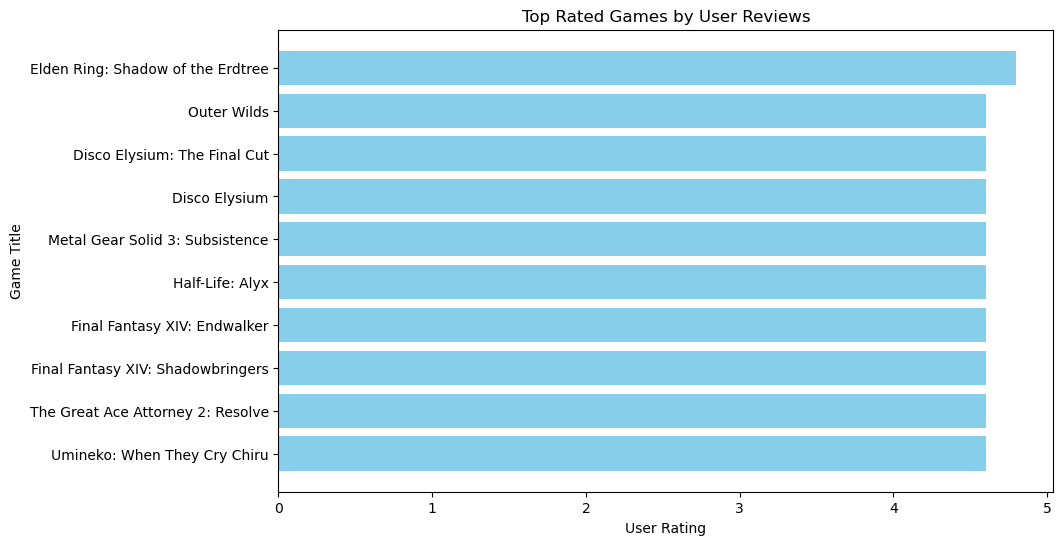

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned file
df = pd.read_csv("games_clean.csv")

top_games = (
    df.dropna(subset=["Rating", "Number of Reviews"])
      .sort_values(by=["Rating", "Number of Reviews"], ascending=[False, False])
      .head(10)
)

plt.figure(figsize=(10,6))
plt.barh(top_games["Game_Title"], top_games["Rating"], color="skyblue")
plt.xlabel("User Rating")
plt.ylabel("Game Title")
plt.title("Top Rated Games by User Reviews")
plt.gca().invert_yaxis()  # highest rating at top
plt.show()

2. Which developers (Teams) have the highest average ratings?

                                          Team  Rating
0                               07th Expansion    4.60
319               Konami Digital Entertainment    4.60
29                    Activision, FromSoftware    4.60
87                  Bay 12 Games, Kitfox Games    4.60
741                                      ZA/UM    4.60
702                                      Valve    4.60
288        Inlusio Interactive, IO Interactive    4.60
572  Sony Computer Entertainment, FromSoftware    4.60
365      Mobius Digital, Annapurna Interactive    4.55
239  FromSoftware, Sony Computer Entertainment    4.55


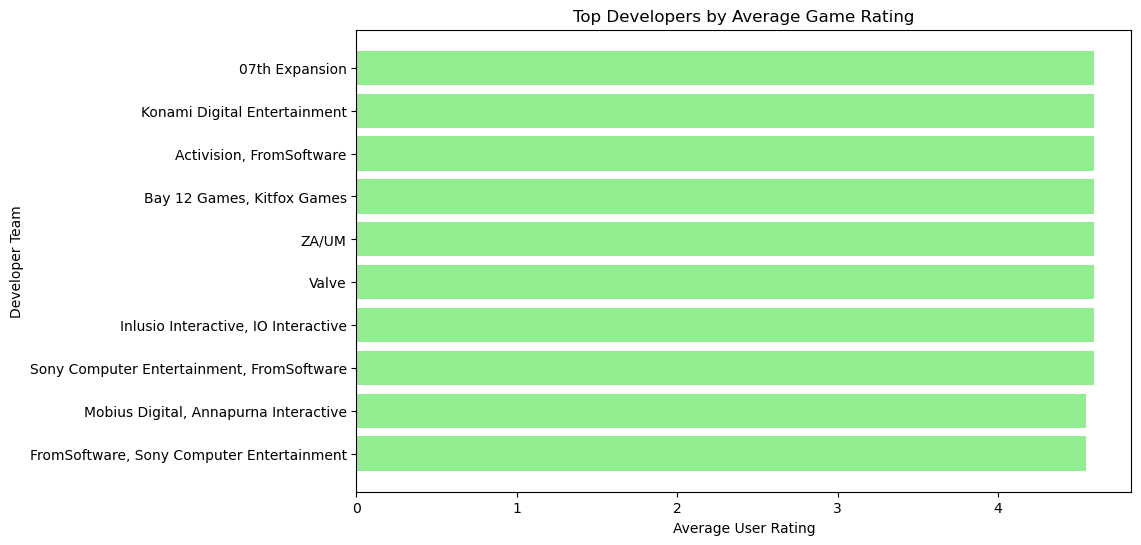

In [12]:
import pandas as pd

df = pd.read_csv("games_clean.csv")

# Drop rows with missing ratings or teams
df_team = df.dropna(subset=["Team", "Rating"])

# Group by Team and compute average rating
avg_ratings = (
    df_team.groupby("Team", as_index=False)["Rating"]
           .mean()
           .sort_values(by="Rating", ascending=False)
)

print(avg_ratings.head(10))  # top 10 developers

import matplotlib.pyplot as plt

top_devs = avg_ratings.head(10)

plt.figure(figsize=(10,6))
plt.barh(top_devs["Team"], top_devs["Rating"], color="lightgreen")
plt.xlabel("Average User Rating")
plt.ylabel("Developer Team")
plt.title("Top Developers by Average Game Rating")
plt.gca().invert_yaxis()  # highest rating at top
plt.show()

3. What are the most common genres in the dataset?

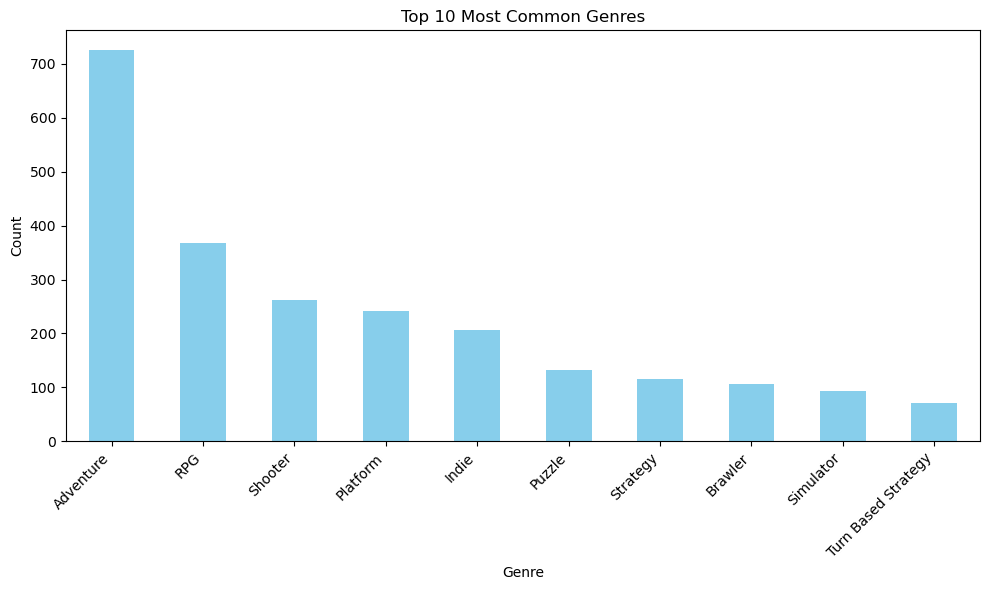

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("games_clean.csv")

# --- Split and count genres ---
# Ensure Genres column exists
if "Genres" in df.columns:
    # Drop NaN values
    genres_series = df["Genres"].dropna()

    # Split comma-separated genres into individual values
    all_genres = genres_series.str.split(",").explode().str.strip()

    # Count frequency of each genre
    genre_counts = all_genres.value_counts().head(10)

    # --- Visualization ---
    plt.figure(figsize=(10,6))
    genre_counts.plot(kind="bar", color="skyblue")
    plt.xlabel("Genre")
    plt.ylabel("Count")
    plt.title("Top 10 Most Common Genres")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

4. Which games have the highest backlog compared to wishlist?

                      Game_Title  Backlogs  Wishlist  Backlog_Wishlist_Ratio
438                     Paladins     188.0      16.0               11.750000
898                      Figment     392.0      35.0               11.200000
553                     Fortnite     470.0      47.0               10.000000
610                   Pokémon Go     197.0      22.0                8.954545
504    Half-Life: Opposing Force     838.0      95.0                8.821053
669                    Destiny 2     845.0     103.0                8.203883
681                   Brawlhalla     294.0      36.0                8.166667
747        BioShock 2 Remastered    2000.0     246.0                8.130081
757  Borderlands: The Pre-Sequel    1900.0     238.0                7.983193
829          PUBG: Battlegrounds     253.0      32.0                7.906250


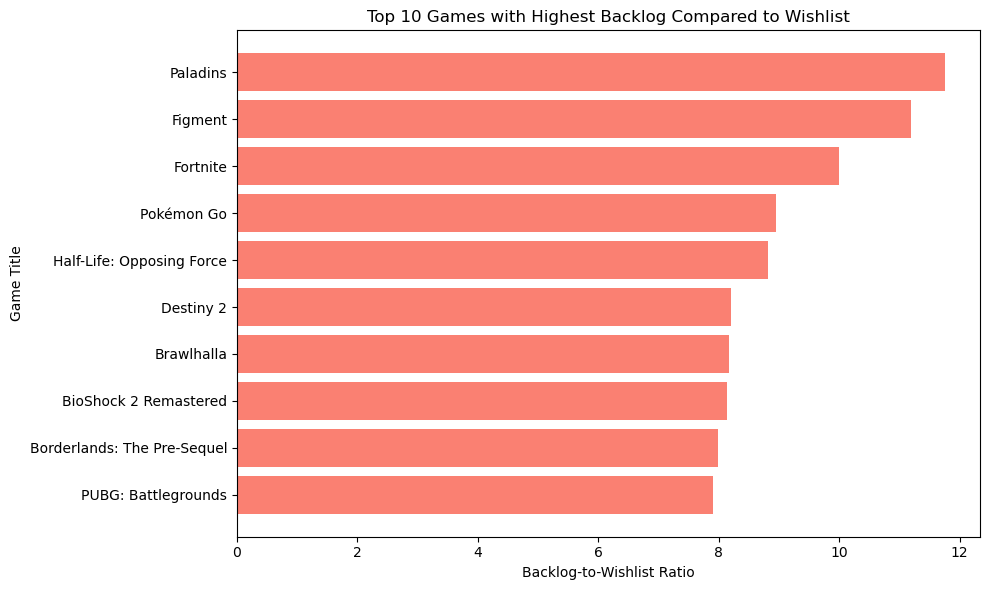

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("games_clean.csv")

# --- Ensure numeric columns ---
df["Backlogs"] = pd.to_numeric(df["Backlogs"], errors="coerce")
df["Wishlist"] = pd.to_numeric(df["Wishlist"], errors="coerce")

# --- Compute backlog-to-wishlist ratio ---
df["Backlog_Wishlist_Ratio"] = df["Backlogs"] / df["Wishlist"]

# --- Drop rows with missing or zero wishlist to avoid division errors ---
df = df.dropna(subset=["Backlogs", "Wishlist"])
df = df[df["Wishlist"] > 0]

# --- Sort by ratio and select top 10 ---
top_backlog_games = df.sort_values(by="Backlog_Wishlist_Ratio", ascending=False).head(10)

print(top_backlog_games[["Game_Title", "Backlogs", "Wishlist", "Backlog_Wishlist_Ratio"]])

# --- Visualization ---
plt.figure(figsize=(10,6))
plt.barh(top_backlog_games["Game_Title"], top_backlog_games["Backlog_Wishlist_Ratio"], color="salmon")
plt.xlabel("Backlog-to-Wishlist Ratio")
plt.ylabel("Game Title")
plt.title("Top 10 Games with Highest Backlog Compared to Wishlist")
plt.gca().invert_yaxis()  # highest ratio at top
plt.tight_layout()
plt.show()

5. What is the game release trend across years?

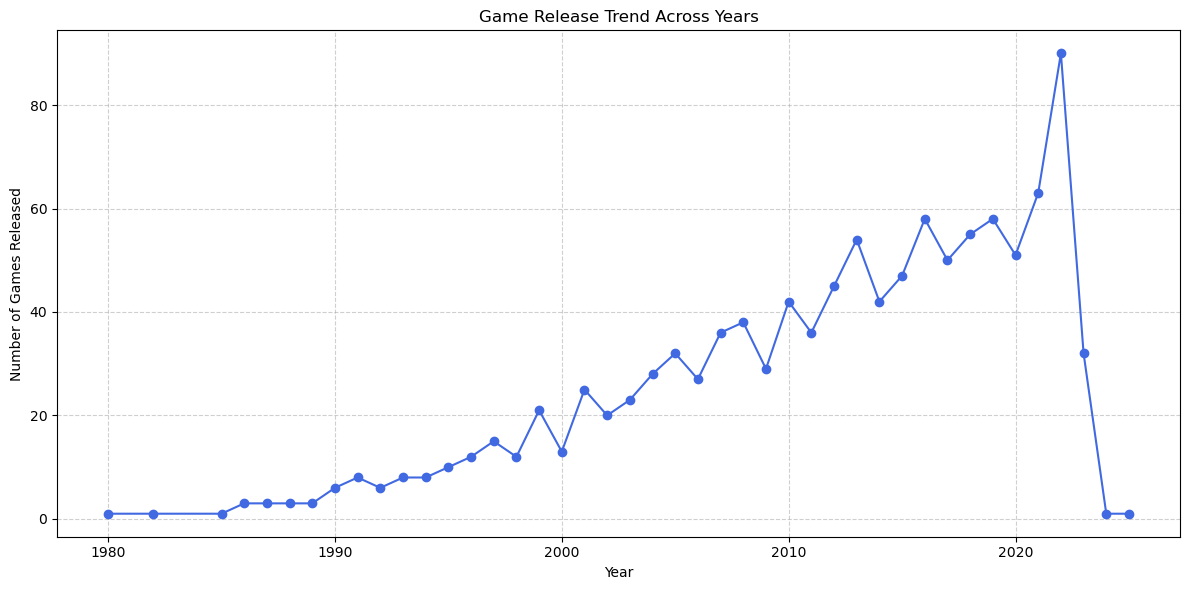

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("games_clean.csv")

# --- Ensure Release Date is datetime ---
df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce")

# --- Extract Year ---
df["Release_Year"] = df["Release Date"].dt.year

# --- Count games per year ---
release_trend = df["Release_Year"].value_counts().sort_index()

# --- Visualization ---
plt.figure(figsize=(12,6))
release_trend.plot(kind="line", marker="o", color="royalblue")
plt.xlabel("Year")
plt.ylabel("Number of Games Released")
plt.title("Game Release Trend Across Years")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

6. What is the distribution of user ratings?

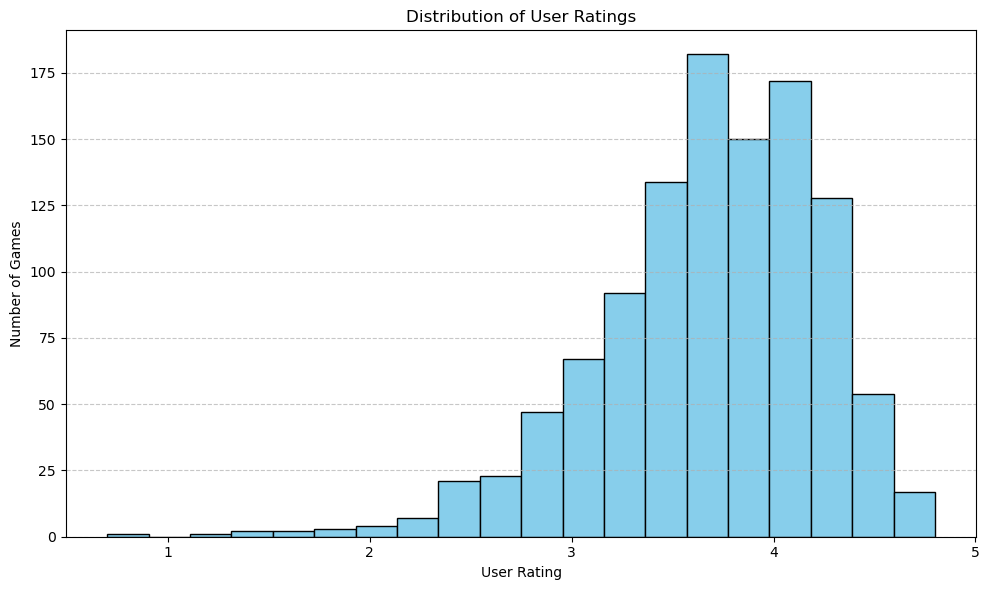

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("games_clean.csv")

# --- Ensure Rating is numeric ---
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")

# --- Drop missing values ---
ratings = df["Rating"].dropna()

# --- Visualization: Histogram ---
plt.figure(figsize=(10,6))
plt.hist(ratings, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("User Rating")
plt.ylabel("Number of Games")
plt.title("Distribution of User Ratings")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

7. What are the top 10 most wishlisted games?

                                    Game_Title  Wishlist
618  The Legend of Zelda: Tears of the Kingdom    5400.0
0                                   Elden Ring    4800.0
6                                        Omori    3800.0
31         NieR Replicant ver.1.22474487139...    3700.0
1                                        Hades    3600.0
9                               NieR: Automata    3600.0
11                                       Stray    3400.0
35                   Sekiro: Shadows Die Twice    3400.0
14                                  Bloodborne    3300.0
7                                Metroid Dread    3300.0


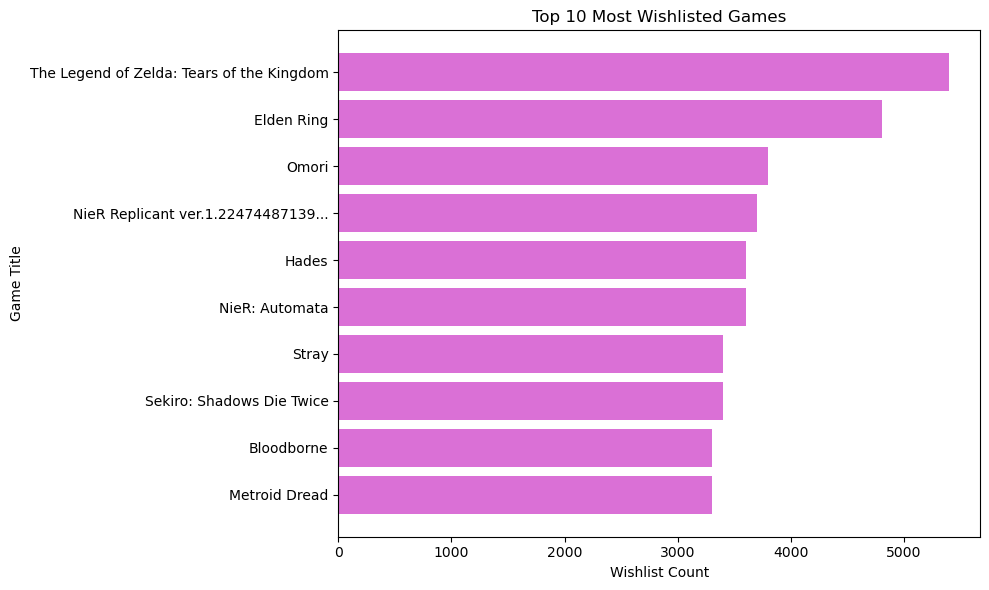

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("games_clean.csv")

# --- Ensure Wishlist is numeric ---
df["Wishlist"] = pd.to_numeric(df["Wishlist"], errors="coerce")

# --- Drop missing values ---
df = df.dropna(subset=["Wishlist"])

# --- Sort by Wishlist and select top 10 ---
top_wishlist = df.sort_values(by="Wishlist", ascending=False).head(10)

print(top_wishlist[["Game_Title", "Wishlist"]])

# --- Visualization ---
plt.figure(figsize=(10,6))
plt.barh(top_wishlist["Game_Title"], top_wishlist["Wishlist"], color="orchid")
plt.xlabel("Wishlist Count")
plt.ylabel("Game Title")
plt.title("Top 10 Most Wishlisted Games")
plt.gca().invert_yaxis()  # highest wishlist at top
plt.tight_layout()
plt.show()

8. What’s the average number of plays per genre?

Genres
MOBA                   8750.000000
Shooter                6138.832061
Racing                 6099.297297
Platform               5660.041494
Turn Based Strategy    5387.098592
Adventure              5227.464187
Brawler                4979.150943
RPG                    4858.152174
Simulator              4544.340426
Tactical               4276.880952
Name: Plays, dtype: float64


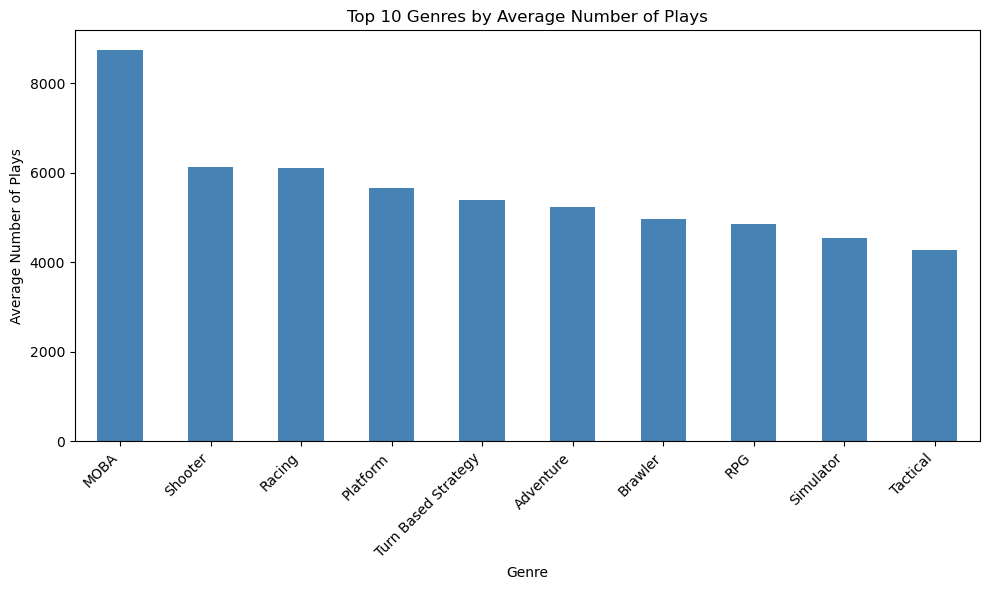

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("games_clean.csv")

# --- Ensure Plays is numeric ---
df["Plays"] = pd.to_numeric(df["Plays"], errors="coerce")

# --- Drop missing values ---
df = df.dropna(subset=["Genres", "Plays"])

# --- Split comma-separated genres into individual values ---
genre_play = df.assign(Genres=df["Genres"].str.split(",")).explode("Genres")
genre_play["Genres"] = genre_play["Genres"].str.strip()

# --- Group by genre and calculate average plays ---
avg_plays = genre_play.groupby("Genres")["Plays"].mean().sort_values(ascending=False)

# --- Select top 10 genres ---
top_avg_plays = avg_plays.head(10)

print(top_avg_plays)

# --- Visualization ---
plt.figure(figsize=(10,6))
top_avg_plays.plot(kind="bar", color="steelblue")
plt.xlabel("Genre")
plt.ylabel("Average Number of Plays")
plt.title("Top 10 Genres by Average Number of Plays")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

9. Which developer studios are the most productive and impactful?

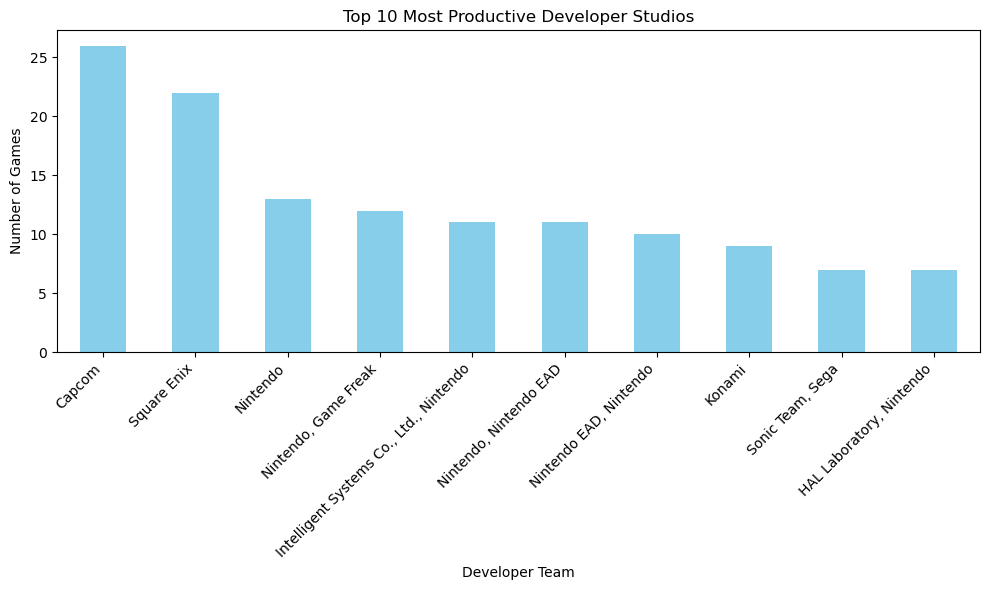

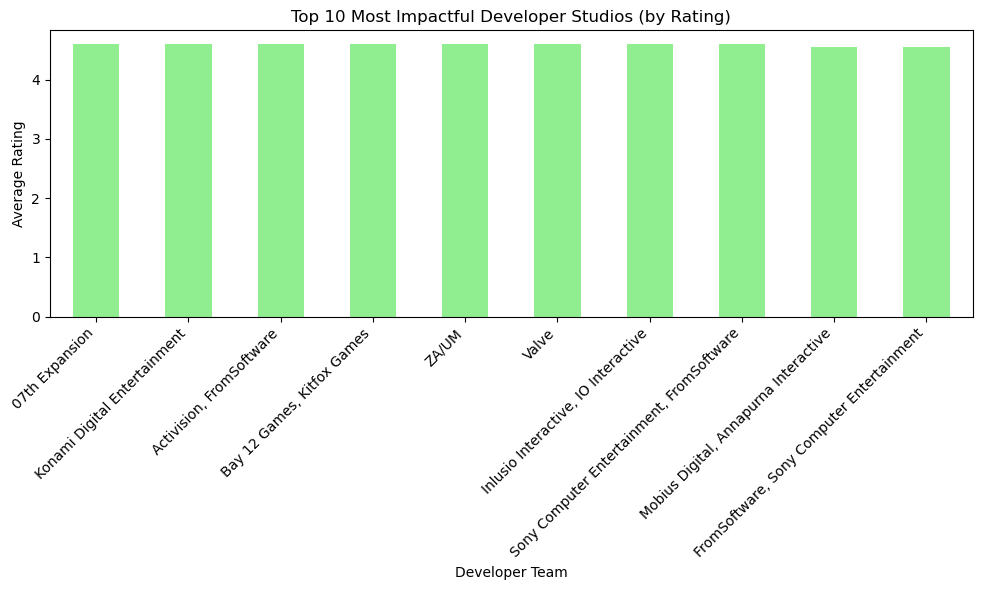

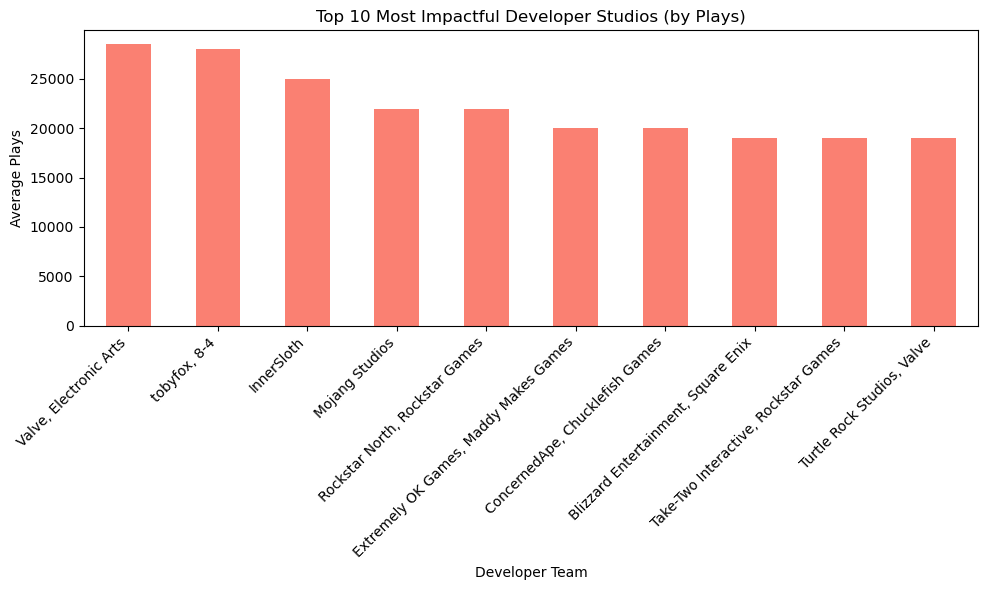

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("games_clean.csv")

# --- Ensure numeric columns ---
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
df["Plays"] = pd.to_numeric(df["Plays"], errors="coerce")
df["Wishlist"] = pd.to_numeric(df["Wishlist"], errors="coerce")

# --- Drop missing values for key columns ---
df = df.dropna(subset=["Team", "Game_Title"])

# --- 1. Productive developers: count of games ---
prod_counts = df.groupby("Team")["Game_Title"].count().sort_values(ascending=False).head(10)

# --- 2. Impactful developers: average rating ---
impact_ratings = df.groupby("Team")["Rating"].mean().sort_values(ascending=False).head(10)

# --- 3. Impactful developers: average plays (optional) ---
impact_plays = df.groupby("Team")["Plays"].mean().sort_values(ascending=False).head(10)

# --- Visualization: Productive developers ---
plt.figure(figsize=(10,6))
prod_counts.plot(kind="bar", color="skyblue")
plt.xlabel("Developer Team")
plt.ylabel("Number of Games")
plt.title("Top 10 Most Productive Developer Studios")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Visualization: Impactful developers (by rating) ---
plt.figure(figsize=(10,6))
impact_ratings.plot(kind="bar", color="lightgreen")
plt.xlabel("Developer Team")
plt.ylabel("Average Rating")
plt.title("Top 10 Most Impactful Developer Studios (by Rating)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Visualization: Impactful developers (by plays) ---
plt.figure(figsize=(10,6))
impact_plays.plot(kind="bar", color="salmon")
plt.xlabel("Developer Team")
plt.ylabel("Average Plays")
plt.title("Top 10 Most Impactful Developer Studios (by Plays)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

vgsales.csv (Sales Data Only)

10. Which region generates the most game sales?

Total Sales by Region (in Millions of Units):
        Region  Total Sales (Millions)
0     NA_Sales                 4392.95
1     EU_Sales                 2434.13
2     JP_Sales                 1291.00
3  Other_Sales                  797.75

Region with the most sales: NA_Sales with 4392.95 million units.


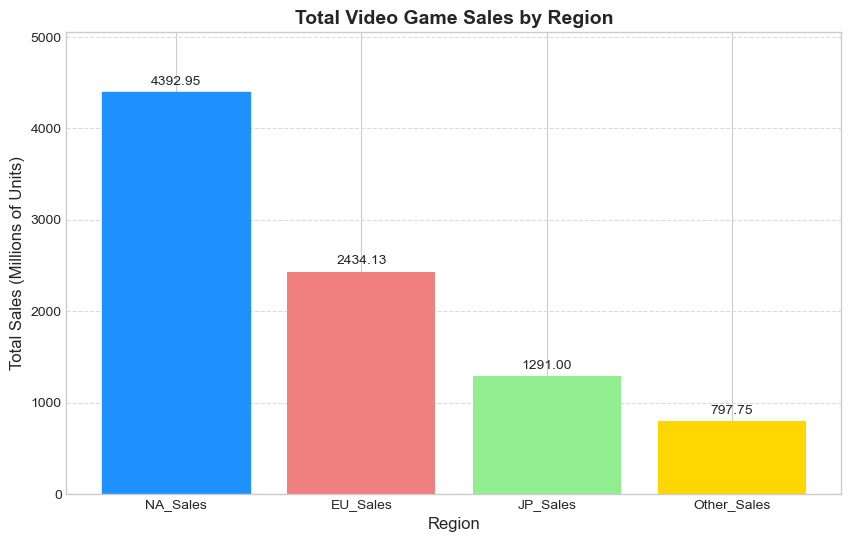

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('vgsales_clean.csv')

# The sales columns are 'NA_Sales', 'EU_Sales', 'JP_Sales', and 'Other_Sales'
sales_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

# Calculate the total sales for each region
total_sales_by_region = df[sales_columns].sum()

# Convert the Series to a DataFrame for easier plotting and printing, and rename the index for clarity
total_sales_df = total_sales_by_region.to_frame(name='Total Sales (Millions)').reset_index()
total_sales_df.columns = ['Region', 'Total Sales (Millions)']

# Sort the data for the plot
total_sales_df = total_sales_df.sort_values(by='Total Sales (Millions)', ascending=False)

# Identify the top region
most_sales_region = total_sales_df.iloc[0]['Region']
most_sales_value = total_sales_df.iloc[0]['Total Sales (Millions)']

# --- Visualization for Jupyter Notebook ---

# Set a style for the plot
plt.style.use('seaborn-v0_8-whitegrid')

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(total_sales_df['Region'], total_sales_df['Total Sales (Millions)'], color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])

# Add the value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 50, f'{yval:.2f}', ha='center', va='bottom')

# Highlight the top region
bars[0].set_color('dodgerblue')

# Set labels and title
plt.xlabel('Region', fontsize=12)
plt.ylabel('Total Sales (Millions of Units)', fontsize=12)
plt.title('Total Video Game Sales by Region', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, total_sales_df['Total Sales (Millions)'].max() * 1.15) # Adjust y-limit for labels

# Save the plot
plt.savefig('total_sales_by_region.png')

# Print the data to display the results
print("Total Sales by Region (in Millions of Units):")
print(total_sales_df)
print(f"\nRegion with the most sales: {most_sales_region} with {most_sales_value:.2f} million units.")

11. What are the best-selling platforms?

Top 10 Best-Selling Platforms (in Millions of Units):
  Platform  Total Global Sales (Millions)
0      PS2                        1255.64
1     X360                         979.96
2      PS3                         957.84
3      Wii                         926.69
4       DS                         822.49
5       PS                         730.66
6      GBA                         318.50
7      PSP                         296.28
8      PS4                         278.10
9       PC                         258.82


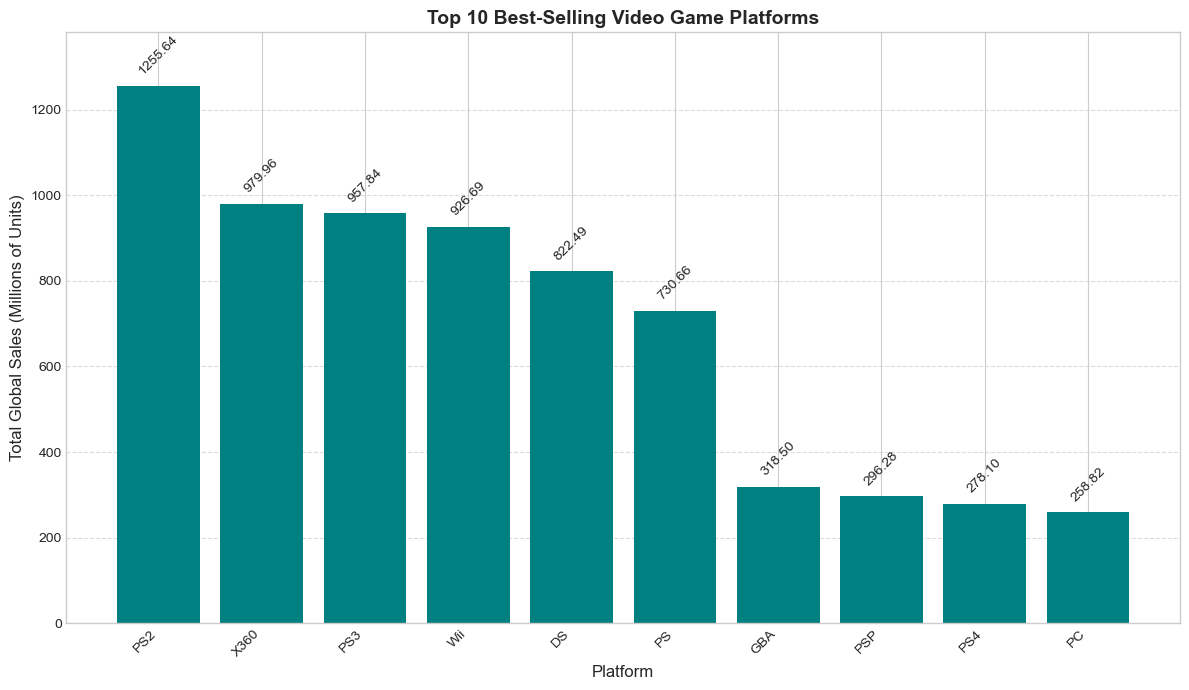

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('vgsales_clean.csv')

# Calculate total Global_Sales for each Platform
platform_sales = df.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=False)

# Select the top 10 best-selling platforms
top_10_platforms = platform_sales.head(10)

# Convert the Series to a DataFrame for cleaner display
top_10_df = top_10_platforms.reset_index()
top_10_df.columns = ['Platform', 'Total Global Sales (Millions)']

# --- Visualization for Jupyter Notebook ---

# Set a style for the plot
plt.style.use('seaborn-v0_8-whitegrid')

# Create the bar chart for the top 10 platforms
plt.figure(figsize=(12, 7))
bars = plt.bar(top_10_df['Platform'], top_10_df['Total Global Sales (Millions)'], color='teal')

# Add the value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 20, f'{yval:.2f}', ha='center', va='bottom', rotation=45)

# Set labels and title
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Total Global Sales (Millions of Units)', fontsize=12)
plt.title('Top 10 Best-Selling Video Game Platforms', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, top_10_df['Total Global Sales (Millions)'].max() * 1.1) # Adjust y-limit for labels

# Save the plot
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.savefig('top_10_platforms_sales.png')

# Print the top 10 data
print("Top 10 Best-Selling Platforms (in Millions of Units):")
print(top_10_df)

12. What’s the trend of game releases and sales over years?

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19720\1644554199.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Year'] = df_cleaned['Year'].astype(int)


Game Release and Sales Trends by Year (Head):
      Release_Count  Total_Sales
Year                            
1980              9        11.38
1981             46        35.77
1982             36        28.86
1983             17        16.79
1984             14        50.36

Game Release and Sales Trends by Year (Tail):
      Release_Count  Total_Sales
Year                            
2014            582       337.05
2015            614       264.44
2016            344        70.93
2017              3         0.05
2020              1         0.29

Data saved to game_trends_by_year.csv


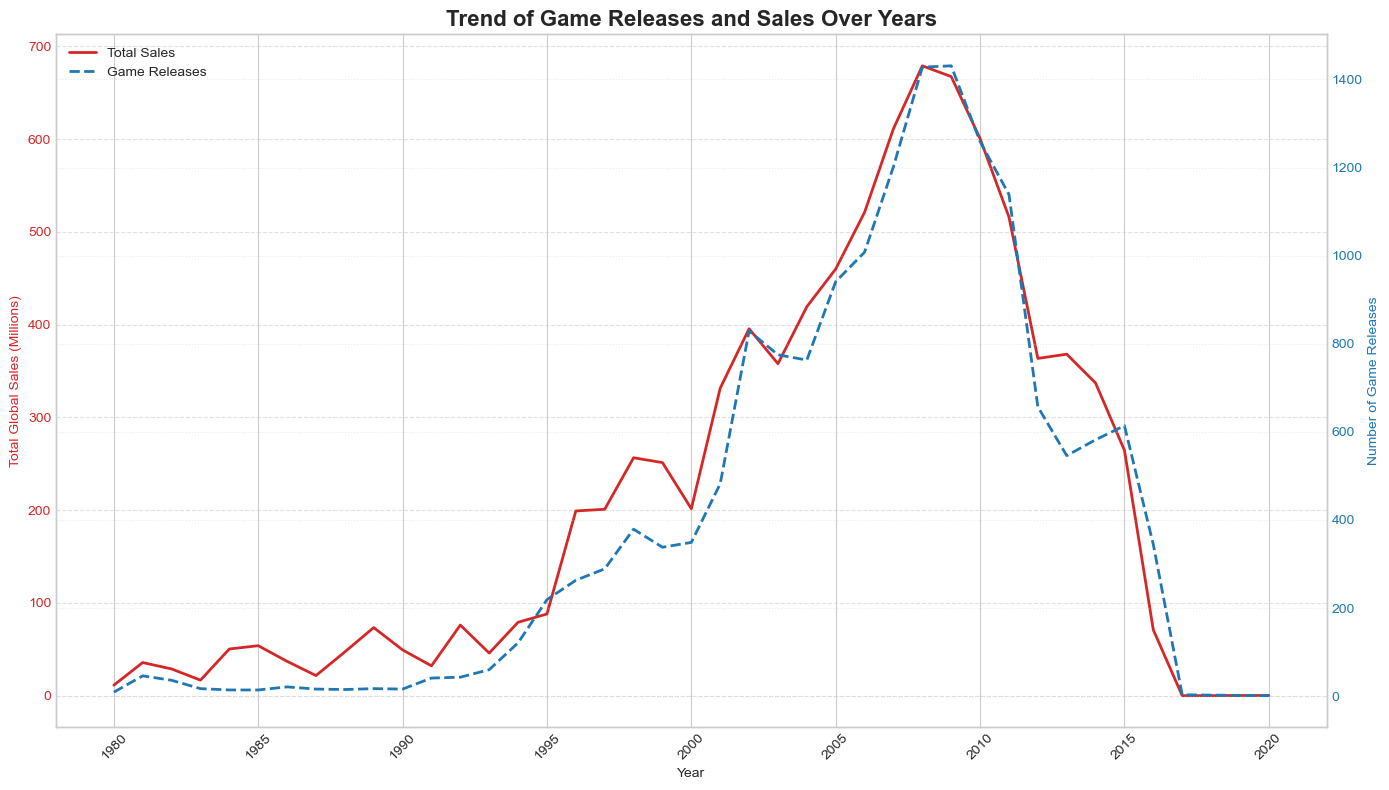

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('vgsales_clean.csv')

# --- Data Preparation ---

# Drop rows with NaN in 'Year' and convert 'Year' to integer
df_cleaned = df.dropna(subset=['Year'])
df_cleaned['Year'] = df_cleaned['Year'].astype(int)

# 1. Calculate Game Releases (Count) per Year
releases_per_year = df_cleaned.groupby('Year').size().rename('Release_Count')

# 2. Calculate Total Global Sales (Sum) per Year
sales_per_year = df_cleaned.groupby('Year')['Global_Sales'].sum().rename('Total_Sales')

# 3. Combine the series into a single DataFrame
trend_df = pd.concat([releases_per_year, sales_per_year], axis=1).sort_index()

# Print the head and tail of the trend data
print("Game Release and Sales Trends by Year (Head):")
print(trend_df.head())
print("\nGame Release and Sales Trends by Year (Tail):")
print(trend_df.tail())

# --- Visualization for Jupyter Notebook (Dual-Axis Plot) ---

# Set a style for the plot
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Sales Trend on primary axis (ax1)
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Global Sales (Millions)', color=color)
ax1.plot(trend_df.index, trend_df['Total_Sales'], color=color, linewidth=2, label='Total Sales')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Create secondary axis (ax2) for Releases
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Number of Game Releases', color=color)
ax2.plot(trend_df.index, trend_df['Release_Count'], color=color, linewidth=2, linestyle='--', label='Game Releases')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(axis='y', linestyle=':', alpha=0.4)

# Set title and X-axis ticks
plt.title('Trend of Game Releases and Sales Over Years', fontsize=16, fontweight='bold')
# Only show every 5th year for cleaner x-axis labels
years = trend_df.index.tolist()
tick_years = years[::5] + [years[-1]] if years[-1] not in years[::5] else years[::5]
ax1.set_xticks(tick_years)
ax1.tick_params(axis='x', rotation=45)

# Add legends (combined from both axes)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Save the plot
plt.tight_layout()
plt.savefig('releases_and_sales_trend.png')

# Output the data to a CSV for user reference, especially for Power BI
trend_df.to_csv('game_trends_by_year.csv')

print("\nData saved to game_trends_by_year.csv")

13. Who are the top publishers by sales?

Top 10 Best-Selling Publishers (in Millions of Units):
                      Publisher  Total Global Sales (Millions)
0                      Nintendo                        1786.54
1               Electronic Arts                        1110.32
2                    Activision                         727.46
3   Sony Computer Entertainment                         607.50
4                       Ubisoft                         474.72
5          Take-Two Interactive                         399.54
6                           THQ                         340.77
7  Konami Digital Entertainment                         283.64
8                          Sega                         272.99
9            Namco Bandai Games                         254.09


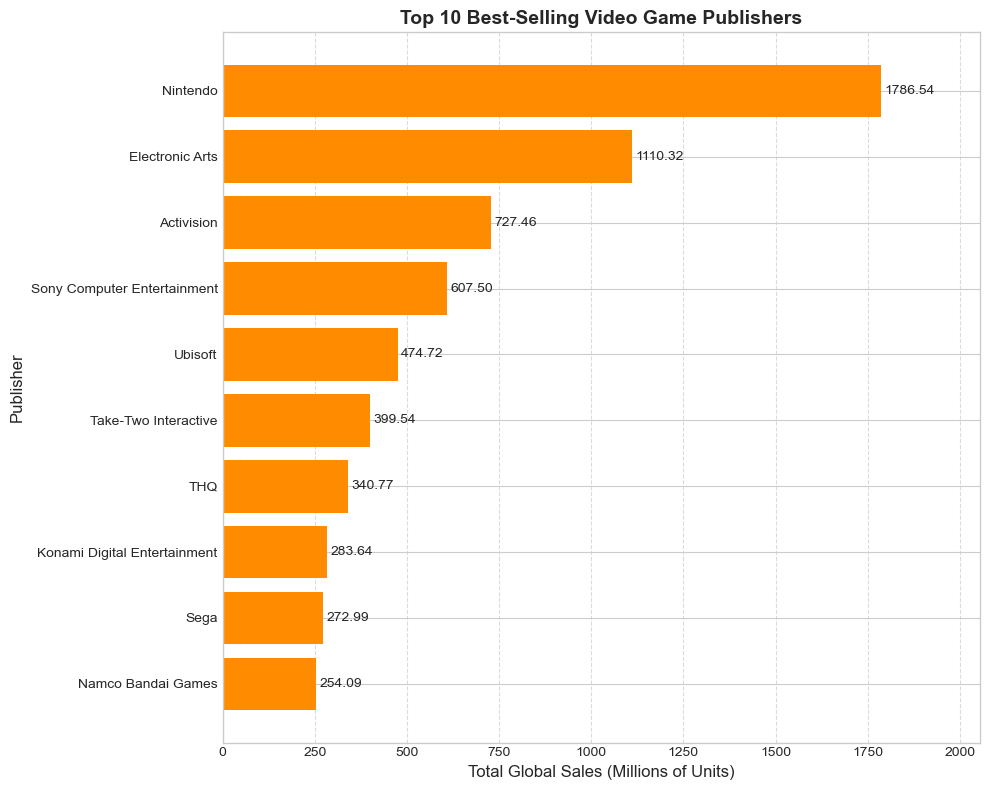

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('vgsales_clean.csv')

# Calculate total Global_Sales for each Publisher
publisher_sales = df.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=False)

# Select the top 10 best-selling publishers
top_10_publishers = publisher_sales.head(10)

# Convert the Series to a DataFrame for cleaner display
top_10_df = top_10_publishers.reset_index()
top_10_df.columns = ['Publisher', 'Total Global Sales (Millions)']

# --- Visualization for Jupyter Notebook ---

# Set a style for the plot
plt.style.use('seaborn-v0_8-whitegrid')

# Create the horizontal bar chart for the top 10 publishers (easier for long names)
plt.figure(figsize=(10, 8))
# Plotting horizontally, so switch x and y
bars = plt.barh(top_10_df['Publisher'], top_10_df['Total Global Sales (Millions)'], color='darkorange')

# Reverse the order so the largest bar is at the top
plt.gca().invert_yaxis()

# Add the value labels at the end of the bars
for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 10, bar.get_y() + bar.get_height()/2, f'{xval:.2f}', va='center')

# Set labels and title
plt.xlabel('Total Global Sales (Millions of Units)', fontsize=12)
plt.ylabel('Publisher', fontsize=12)
plt.title('Top 10 Best-Selling Video Game Publishers', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, top_10_df['Total Global Sales (Millions)'].max() * 1.15) # Adjust x-limit for labels

# Save the plot
plt.tight_layout()
plt.savefig('top_10_publishers_sales.png')

# Print the top 10 data
print("Top 10 Best-Selling Publishers (in Millions of Units):")
print(top_10_df)

14. Which games are the top 10 best-sellers globally?

Top 10 Best-Selling Games Globally (in Millions of Units):
                  Game Title Platform  Year Publisher  Global Sales (Millions)
0                 Wii Sports      Wii  2006  Nintendo                    82.74
1          Super Mario Bros.      NES  1985  Nintendo                    40.24
2             Mario Kart Wii      Wii  2008  Nintendo                    35.82
3          Wii Sports Resort      Wii  2009  Nintendo                    33.00
4   Pokemon Red/Pokemon Blue       GB  1996  Nintendo                    31.37
5                     Tetris       GB  1989  Nintendo                    30.26
6      New Super Mario Bros.       DS  2006  Nintendo                    30.01
7                   Wii Play      Wii  2006  Nintendo                    29.02
8  New Super Mario Bros. Wii      Wii  2009  Nintendo                    28.62
9                  Duck Hunt      NES  1984  Nintendo                    28.31


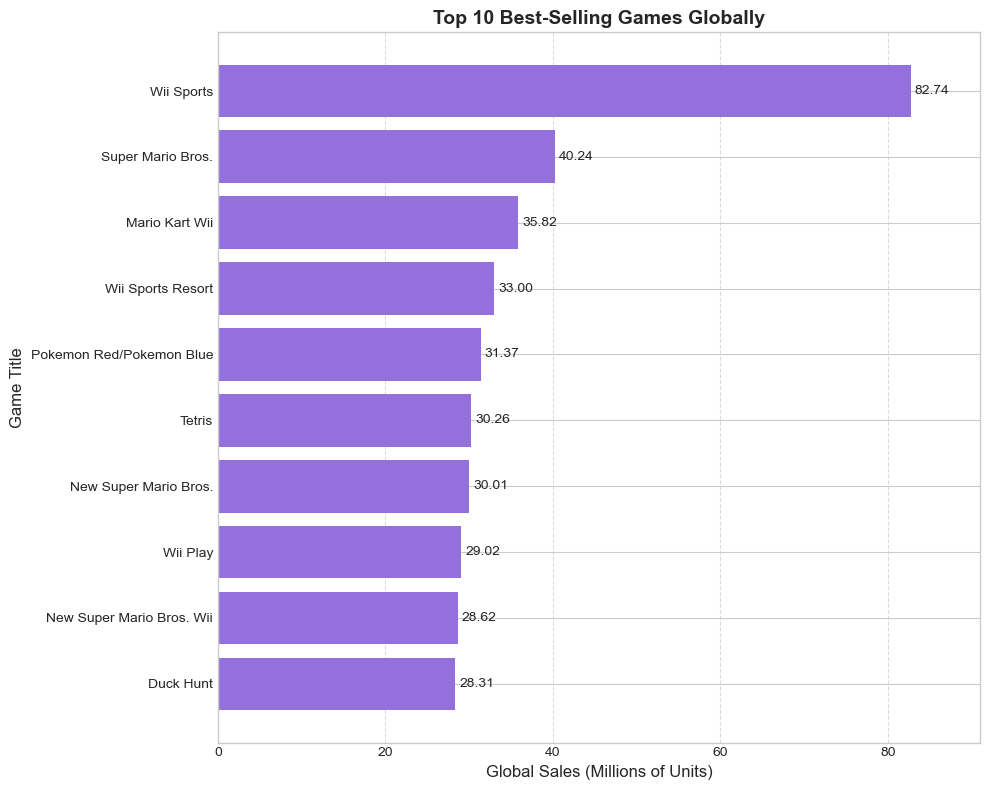

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('vgsales_clean.csv')

# Select the necessary columns and sort by Global_Sales
top_games_df = df[['Game_Title', 'Platform', 'Year', 'Publisher', 'Global_Sales']].sort_values(
    by='Global_Sales', ascending=False
).head(10).reset_index(drop=True)

# Convert Year to integer for cleaner display
top_games_df['Year'] = top_games_df['Year'].fillna(0).astype(int)

# Rename column for display clarity
top_games_df.columns = ['Game Title', 'Platform', 'Year', 'Publisher', 'Global Sales (Millions)']

# --- Visualization for Jupyter Notebook ---

# Set a style for the plot
plt.style.use('seaborn-v0_8-whitegrid')

# Create the horizontal bar chart for the top 10 games
plt.figure(figsize=(10, 8))
# Plotting horizontally
bars = plt.barh(top_games_df['Game Title'], top_games_df['Global Sales (Millions)'], color='mediumpurple')

# Reverse the order so the largest bar is at the top (like a ranked list)
plt.gca().invert_yaxis()

# Add the value labels at the end of the bars
for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 0.5, bar.get_y() + bar.get_height()/2, f'{xval:.2f}', va='center')

# Set labels and title
plt.xlabel('Global Sales (Millions of Units)', fontsize=12)
plt.ylabel('Game Title', fontsize=12)
plt.title('Top 10 Best-Selling Games Globally', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, top_games_df['Global Sales (Millions)'].max() * 1.1) # Adjust x-limit for labels

# Save the plot
plt.tight_layout()
plt.savefig('top_10_games_sales.png')

# Print the top 10 data
print("Top 10 Best-Selling Games Globally (in Millions of Units):")
print(top_games_df)

15. How do regional sales compare for specific platforms?

Regional Sales (in Millions of Units) for Top 5 Platforms:
          NA_Sales  EU_Sales  JP_Sales  Other_Sales
Platform                                           
X360        601.05    280.58     12.43        85.54
PS2         583.84    339.29    139.20       193.44
Wii         507.71    268.38     69.33        80.61
PS3         392.26    343.71     79.99       141.93
DS          390.71    194.65    175.57        60.53


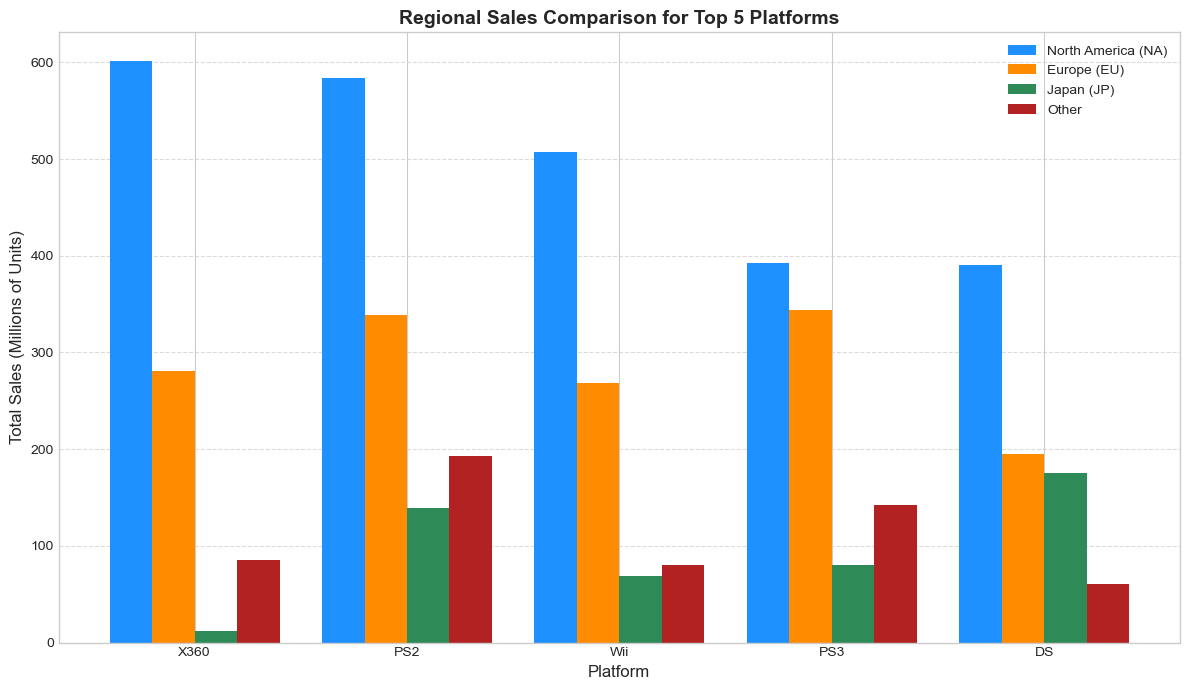

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('vgsales_clean.csv')

# 1. Identify the Top 5 Platforms by Global Sales
platform_sales = df.groupby('Platform')['Global_Sales'].sum().nlargest(5).index.tolist()
# top_5_platforms = ['PS2', 'X360', 'PS3', 'Wii', 'DS'] # Based on previous analysis

# 2. Filter the DataFrame for the Top 5 Platforms
df_top_5 = df[df['Platform'].isin(platform_sales)]

# 3. Group by Platform and sum regional sales
regional_sales_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
sales_by_platform_region = df_top_5.groupby('Platform')[regional_sales_cols].sum()

# 4. Prepare data for plotting (optional but useful for clarity)
plot_df = sales_by_platform_region.sort_values(by='NA_Sales', ascending=False) # Sort by NA_Sales for better visual ordering

# 5. --- Visualization for Jupyter Notebook (Grouped Bar Chart) ---

plt.style.use('seaborn-v0_8-whitegrid')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 7))

# Define bar width and positions
bar_width = 0.2
platforms = plot_df.index
r = np.arange(len(platforms))

# Create bars for each region
rects1 = ax.bar(r - 1.5 * bar_width, plot_df['NA_Sales'], bar_width, label='North America (NA)', color='dodgerblue')
rects2 = ax.bar(r - 0.5 * bar_width, plot_df['EU_Sales'], bar_width, label='Europe (EU)', color='darkorange')
rects3 = ax.bar(r + 0.5 * bar_width, plot_df['JP_Sales'], bar_width, label='Japan (JP)', color='seagreen')
rects4 = ax.bar(r + 1.5 * bar_width, plot_df['Other_Sales'], bar_width, label='Other', color='firebrick')

# Function to add labels on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, rotation=45)

# Uncomment to add labels (can clutter the plot)
# add_labels(rects1)
# add_labels(rects2)
# add_labels(rects3)
# add_labels(rects4)


# Add labels, title, and customize x-axis
ax.set_xlabel('Platform', fontsize=12)
ax.set_ylabel('Total Sales (Millions of Units)', fontsize=12)
ax.set_title('Regional Sales Comparison for Top 5 Platforms', fontsize=14, fontweight='bold')
ax.set_xticks(r)
ax.set_xticklabels(platforms)
ax.legend(loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot
plt.tight_layout()
plt.savefig('regional_sales_by_platform.png')

# Print the data used for the visualization
print("Regional Sales (in Millions of Units) for Top 5 Platforms:")
print(plot_df)

16. How has the market evolved by platform over time?

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19720\1415174837.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Year'] = df_cleaned['Year'].astype(int)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19720\1415174837.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Platform_Group'] = df_cleaned['Platform'].apply(group_platform)


Processed Sales Data for Stacked Area Chart (Head):
Platform_Group   DS  GBA   PS  PS2  PS3  PS4  PSP  Wii  X360  Other
Year                                                               
1980            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  11.38
1981            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  35.77
1982            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  28.86
1983            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  16.79
1984            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  50.36

Data saved to market_evolution_by_platform.csv


<Figure size 1400x800 with 0 Axes>

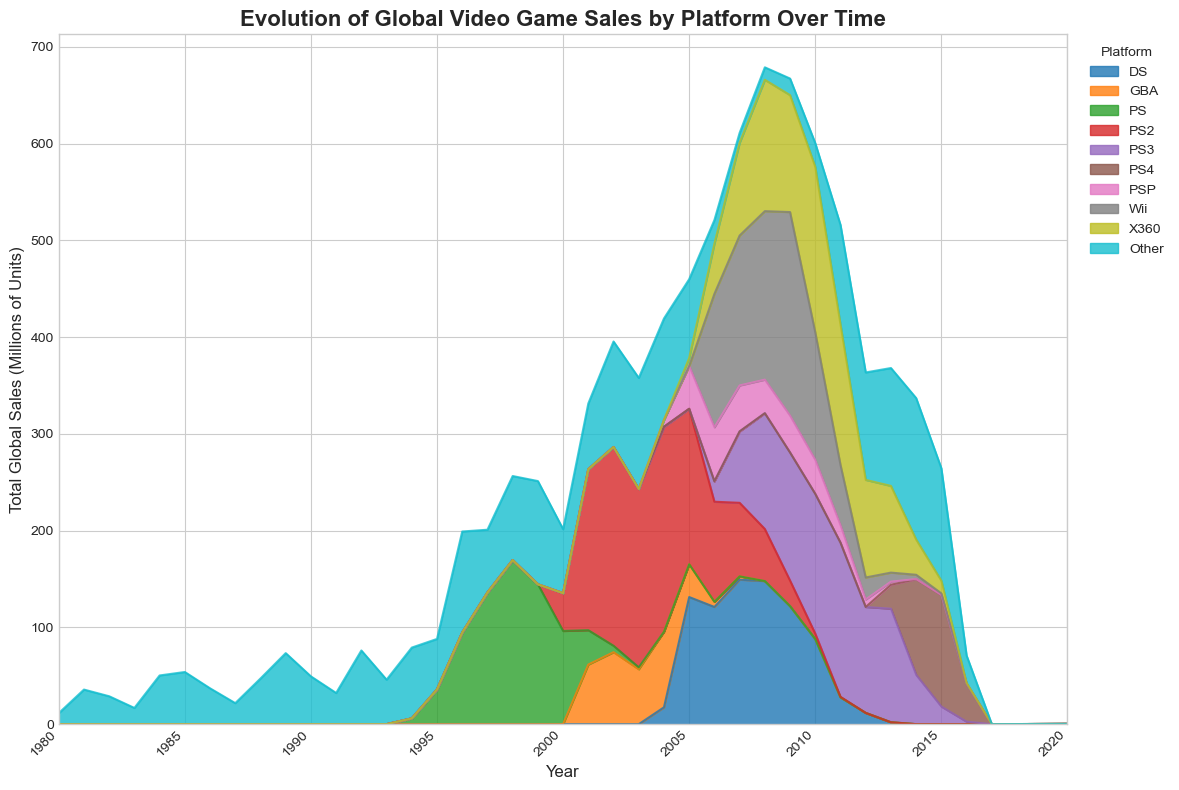

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('vgsales_clean.csv')

# --- Data Preparation ---

# 1. Clean and prepare Year column
df_cleaned = df.dropna(subset=['Year'])
df_cleaned['Year'] = df_cleaned['Year'].astype(int)

# 2. Identify Top Platforms (Top 9 based on prior analysis)
# Recalculate top platforms for robustness
top_platforms = df_cleaned.groupby('Platform')['Global_Sales'].sum().nlargest(9).index.tolist()

# 3. Create Platform_Group column: Top 9 platforms and 'Other'
def group_platform(platform):
    return platform if platform in top_platforms else 'Other'

df_cleaned['Platform_Group'] = df_cleaned['Platform'].apply(group_platform)

# 4. Aggregate Global Sales by Year and Platform_Group
sales_by_year_platform = df_cleaned.groupby(['Year', 'Platform_Group'])['Global_Sales'].sum().reset_index()

# 5. Pivot data for stacked plot (Year as index, Platforms as columns)
sales_pivot = sales_by_year_platform.pivot(index='Year', columns='Platform_Group', values='Global_Sales').fillna(0)

# Reorder columns to put 'Other' at the bottom of the stack
cols = [col for col in sales_pivot.columns if col != 'Other']
cols.append('Other')
sales_pivot = sales_pivot[cols]

# Print the head of the processed data
print("Processed Sales Data for Stacked Area Chart (Head):")
print(sales_pivot.head())

# --- Visualization for Jupyter Notebook (Stacked Area Chart) ---

plt.style.use('seaborn-v0_8-whitegrid')

# Create the stacked area chart
plt.figure(figsize=(14, 8))
sales_pivot.plot(kind='area', stacked=True, figsize=(14, 8), legend=True, alpha=0.8)

# Set labels and title
plt.title('Evolution of Global Video Game Sales by Platform Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Global Sales (Millions of Units)', fontsize=12)

# Adjust X-axis ticks for readability
years = sales_pivot.index.tolist()
# Show every 5th year
tick_years = years[::5] + [years[-1]] if years[-1] not in years[::5] else years[::5]
plt.xticks(tick_years, rotation=45, ha='right')
plt.xlim(sales_pivot.index.min(), sales_pivot.index.max()) # Ensure years are plotted from start to end

# Move legend outside the plot
plt.legend(title='Platform', loc='upper left', bbox_to_anchor=(1.01, 1), ncol=1)

# Save the plot
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for outside legend
plt.savefig('market_evolution_by_platform.png')

# Output the data to a CSV for user reference, especially for Power BI
sales_pivot.to_csv('market_evolution_by_platform.csv')
print("\nData saved to market_evolution_by_platform.csv")

17. What are the regional genre preferences?

Regional Sales (in Millions of Units) by Genre:
              NA_Sales  EU_Sales  JP_Sales  Other_Sales
Genre                                                  
Action          877.83    525.00    159.95       187.38
Sports          683.35    376.85    135.37       134.97
Shooter         582.60    313.27     38.26       102.69
Role-Playing    327.28    188.06    352.31        59.61
Platform        447.05    201.63    130.77        51.59
Misc            410.24    215.98    107.76        75.32
Racing          359.42    238.39     56.69        77.27
Fighting        223.59    101.32     87.35        36.68
Simulation      183.31    113.38     63.70        31.52
Puzzle          123.78     50.78     57.31        12.55
Adventure       105.80     64.13     52.07        16.81
Strategy         68.70     45.34     49.46        11.36

Data saved to regional_genre_sales.csv


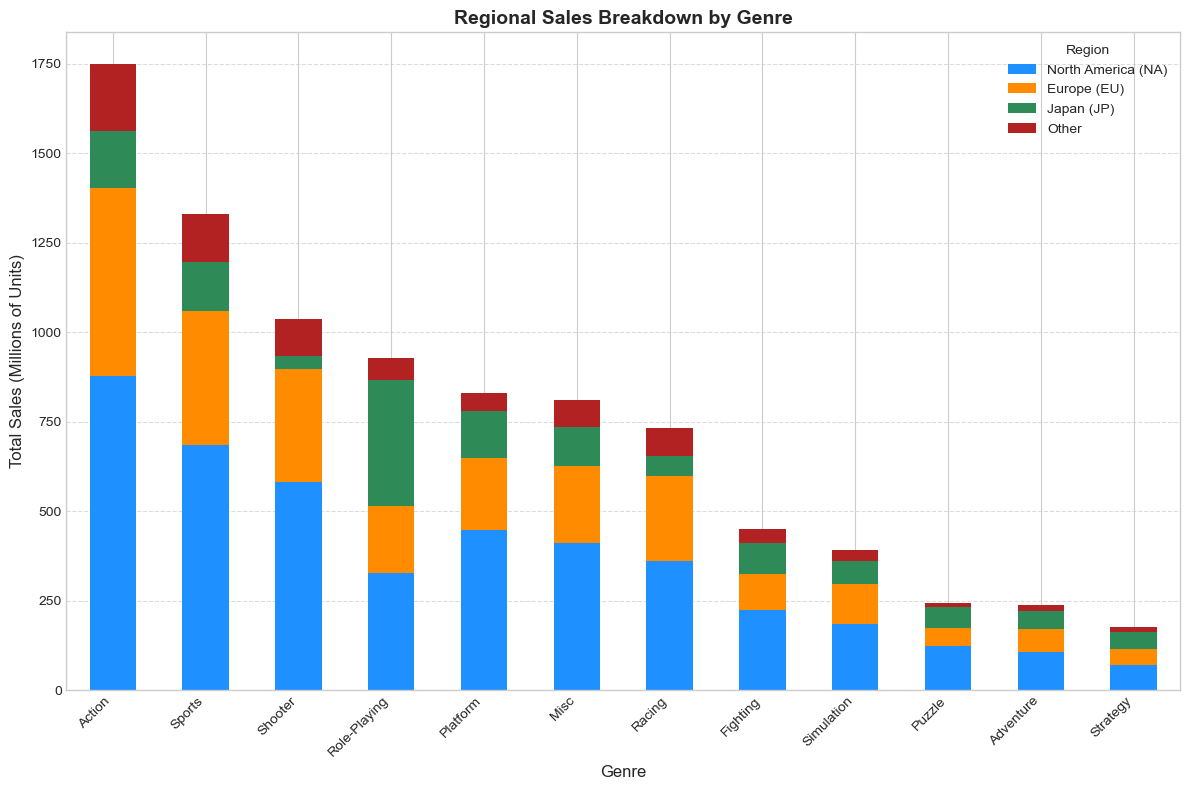

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('vgsales_clean.csv')

# --- Data Preparation ---

regional_sales_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

# 1. Calculate total regional sales for each Genre
genre_sales = df.groupby('Genre')[regional_sales_cols].sum()

# 2. Add Total Sales for sorting
genre_sales['Total_Sales'] = genre_sales.sum(axis=1)

# 3. Sort by Total Sales (descending)
genre_sales = genre_sales.sort_values(by='Total_Sales', ascending=False).drop(columns=['Total_Sales'])

# Print the data used for the visualization
print("Regional Sales (in Millions of Units) by Genre:")
print(genre_sales)

# --- Visualization for Jupyter Notebook (Stacked Bar Chart) ---

plt.style.use('seaborn-v0_8-whitegrid')

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for the regions
colors = {
    'NA_Sales': 'dodgerblue',
    'EU_Sales': 'darkorange',
    'JP_Sales': 'seagreen',
    'Other_Sales': 'firebrick'
}

# Stack the bars
genre_sales[regional_sales_cols].plot(kind='bar', stacked=True, color=colors.values(), ax=ax)

# Set labels and title
ax.set_xlabel('Genre', fontsize=12)
ax.set_ylabel('Total Sales (Millions of Units)', fontsize=12)
ax.set_title('Regional Sales Breakdown by Genre', fontsize=14, fontweight='bold')

# Customize x-axis labels
plt.xticks(rotation=45, ha='right')

# Adjust legend names
handles, labels = ax.get_legend_handles_labels()
new_labels = ['North America (NA)', 'Europe (EU)', 'Japan (JP)', 'Other']
ax.legend(handles, new_labels, title='Region', loc='upper right')

ax.grid(axis='y', linestyle='--', alpha=0.7)

# Save the plot
plt.tight_layout()
plt.savefig('regional_genre_preferences.png')

# Output the data to a CSV for user reference, especially for Power BI
genre_sales.to_csv('regional_genre_sales.csv')
print("\nData saved to regional_genre_sales.csv")

18. What’s the yearly sales change per region?

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19720\2629435825.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Year'] = df_cleaned['Year'].astype(int)


Yearly Sales Change by Region (in Millions of Units):
      NA_Sales  EU_Sales  JP_Sales  Other_Sales
Year                                           
1981     22.81      1.29      0.00         0.20
1982     -6.48     -0.31      0.00        -0.01
1983    -19.16     -0.85      8.10        -0.17
1984     25.52      1.30      6.17         0.56
1985      0.45      2.64      0.29         0.22

... Tail:
      NA_Sales  EU_Sales  JP_Sales  Other_Sales
Year                                           
2014    -22.80     -0.15     -8.13         0.20
2015    -29.15    -27.94     -5.74       -10.01
2016    -80.16    -70.95    -20.02       -22.26
2017    -22.66    -26.76    -13.65        -7.75
2020      0.27      0.00     -0.05         0.02

Data saved to yearly_sales_change_by_region.csv


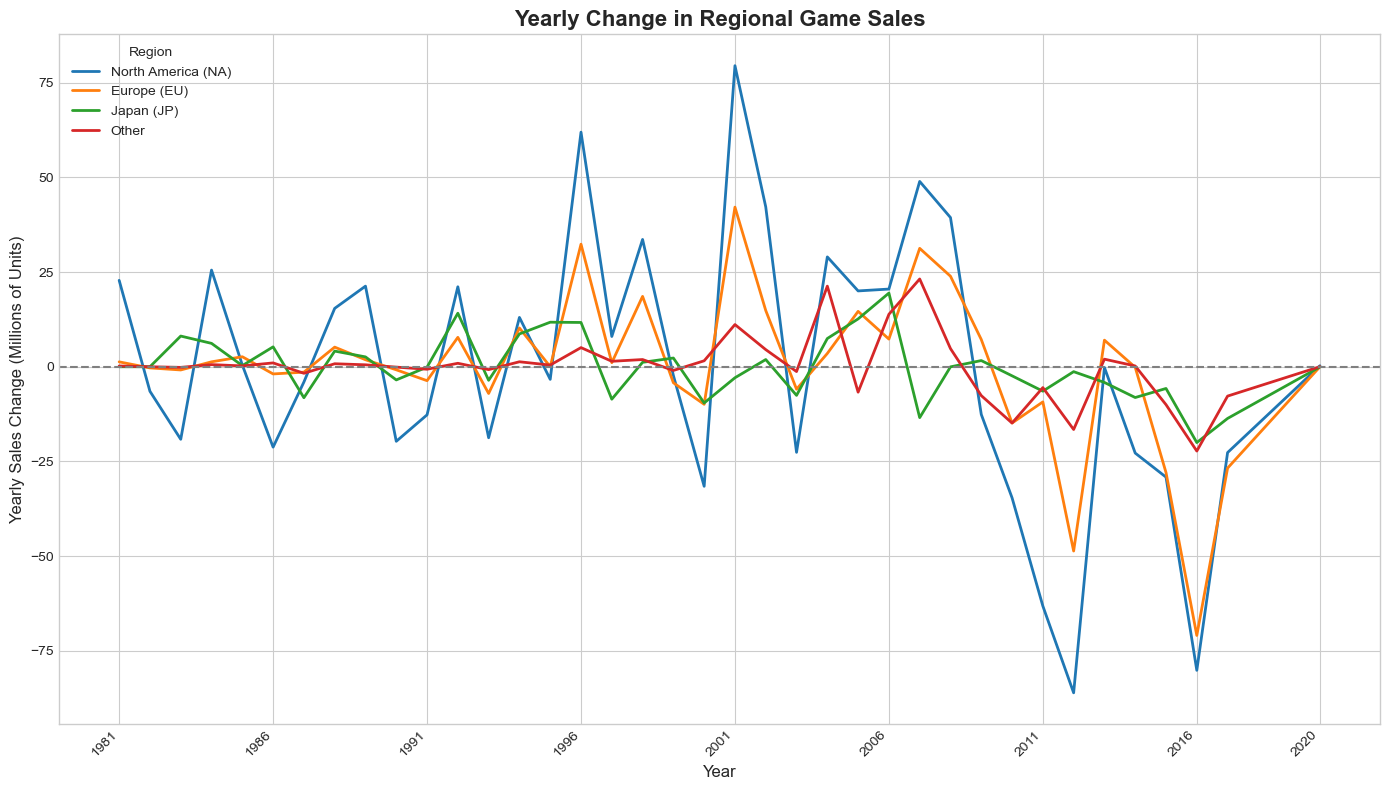

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('vgsales_clean.csv')

# --- Data Preparation ---

# 1. Clean and prepare Year column
df_cleaned = df.dropna(subset=['Year'])
df_cleaned['Year'] = df_cleaned['Year'].astype(int)

regional_sales_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

# 2. Aggregate sales by year
sales_by_year = df_cleaned.groupby('Year')[regional_sales_cols].sum()

# 3. Calculate the yearly change (difference from the previous year)
yearly_change_df = sales_by_year.diff().dropna() # drop the first row as it will be NaN

# Print the head and tail of the change data
print("Yearly Sales Change by Region (in Millions of Units):")
print(yearly_change_df.head())
print("\n... Tail:")
print(yearly_change_df.tail())

# --- Visualization for Jupyter Notebook (Line Chart for Trends) ---

plt.style.use('seaborn-v0_8-whitegrid')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the yearly change for all regions
yearly_change_df.plot(kind='line', ax=ax, linewidth=2)

# Add a horizontal line at y=0 to easily identify growth vs. decline
ax.axhline(0, color='gray', linestyle='--')

# Set labels and title
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Yearly Sales Change (Millions of Units)', fontsize=12)
ax.set_title('Yearly Change in Regional Game Sales', fontsize=16, fontweight='bold')

# Adjust X-axis ticks for readability
years = yearly_change_df.index.tolist()
# Show every 5th year
tick_years = years[::5] + [years[-1]] if years[-1] not in years[::5] else years[::5]
ax.set_xticks(tick_years)
plt.xticks(rotation=45, ha='right')
ax.tick_params(axis='y')

# Customize legend
ax.legend(title='Region', labels=['North America (NA)', 'Europe (EU)', 'Japan (JP)', 'Other'], loc='upper left')

# Save the plot
plt.tight_layout()
plt.savefig('yearly_sales_change_by_region.png')

# Output the data to a CSV for user reference, especially for Power BI
yearly_change_df.to_csv('yearly_sales_change_by_region.csv')
print("\nData saved to yearly_sales_change_by_region.csv")

19. What is the average sales per publisher?

Top 10 Publishers by Average Global Sales (Publishers with at least 5 titles):
                            Publisher  Average Global Sales (Millions)  \
0                            Nintendo                         2.544929   
1  Sony Computer Entertainment Europe                         1.592667   
2              Microsoft Game Studios                         1.300476   
3                  Bethesda Softworks                         1.156901   
4                    Enix Corporation                         1.124667   
5                          SquareSoft                         1.108654   
6                           LucasArts                         0.970444   
7                Take-Two Interactive                         0.967409   
8                         989 Studios                         0.951429   
9                  Hasbro Interactive                         0.951250   

   Game Count  
0         702  
1          15  
2         189  
3          71  
4          30  
5         

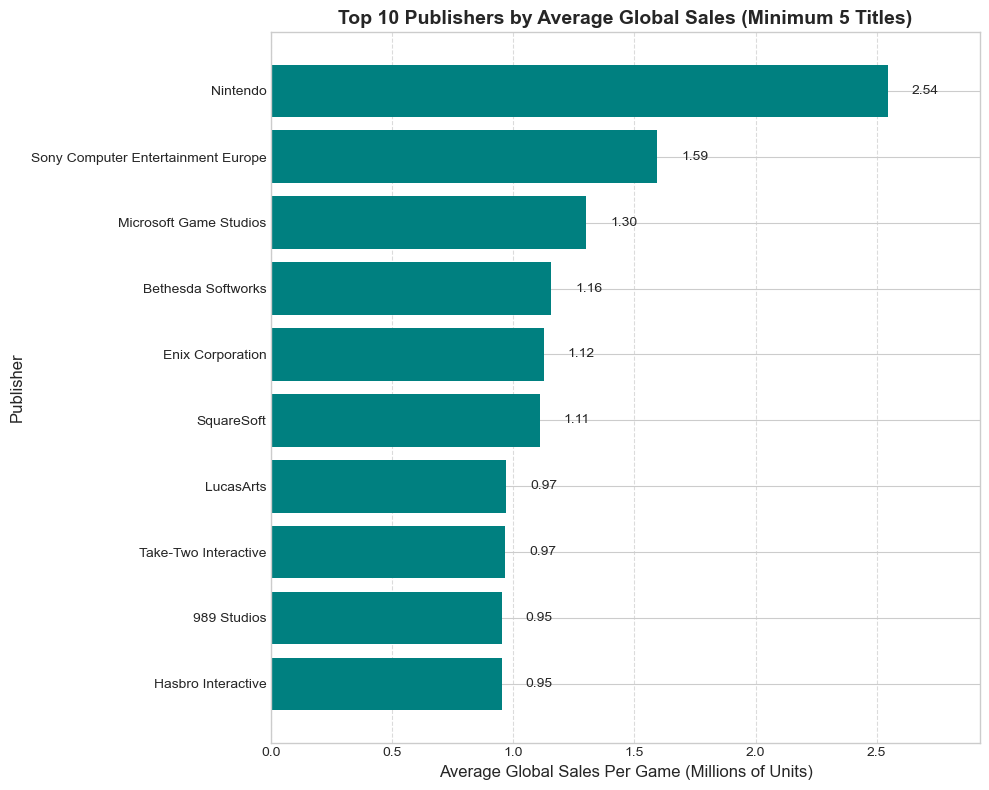

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('vgsales_clean.csv')

# --- Data Preparation ---

# Group by Publisher and calculate both the mean Global_Sales and the count of games
publisher_stats = df.groupby('Publisher')['Global_Sales'].agg(['mean', 'count'])
publisher_stats.columns = ['Average Global Sales (Millions)', 'Game Count']

# Sort by Average Global Sales (descending)
publisher_stats = publisher_stats.sort_values(by='Average Global Sales (Millions)', ascending=False)

# Select the top 10 publishers by average sales.
# To ensure meaningful results, let's filter to publishers with at least 5 titles, then take the top 10.
min_games = 5
top_10_avg_publishers_filtered = publisher_stats[publisher_stats['Game Count'] >= min_games].head(10)

# Reset index for plotting and printing
top_10_df = top_10_avg_publishers_filtered.reset_index()

# Print the top 10 filtered data
print(f"Top 10 Publishers by Average Global Sales (Publishers with at least {min_games} titles):")
print(top_10_df)

# --- Visualization for Jupyter Notebook (Bar Chart) ---

# Set a style for the plot
plt.style.use('seaborn-v0_8-whitegrid')

# Create the horizontal bar chart for the top 10 publishers by average sales
plt.figure(figsize=(10, 8))
# Plotting horizontally
bars = plt.barh(top_10_df['Publisher'], top_10_df['Average Global Sales (Millions)'], color='teal')

# Reverse the order so the largest bar is at the top
plt.gca().invert_yaxis()

# Add the value labels at the end of the bars
for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 0.1, bar.get_y() + bar.get_height()/2, f'{xval:.2f}', va='center')

# Set labels and title
plt.xlabel('Average Global Sales Per Game (Millions of Units)', fontsize=12)
plt.ylabel('Publisher', fontsize=12)
plt.title(f'Top 10 Publishers by Average Global Sales (Minimum {min_games} Titles)', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, top_10_df['Average Global Sales (Millions)'].max() * 1.15) # Adjust x-limit for labels

# Save the plot
plt.tight_layout()
plt.savefig('top_10_avg_publishers_sales.png')

# Output the data to a CSV for user reference, especially for Power BI
top_10_df.to_csv('top_10_avg_publishers_sales.csv', index=False)
print("\nData saved to top_10_avg_publishers_sales.csv")

20. What are the top 5 best-selling games per platform?

In [11]:
import pandas as pd

# Load the dataset
df = pd.read_csv('vgsales_clean.csv')

# --- Processing ---

# Get unique platforms
platforms = df['Platform'].unique()

top_games_list = []
platforms_processed = 0

for platform in platforms:
    # 1. Filter data for the current platform
    platform_df = df[df['Platform'] == platform].copy()

    # 2. Sort by Global_Sales and select top 5
    top_5 = platform_df[['Game_Title', 'Global_Sales']].sort_values(
        by='Global_Sales', ascending=False
    ).head(5).copy()

    # 3. Add Platform column for identification
    top_5['Platform'] = platform
    
    # 4. Add Rank column
    top_5['Rank'] = range(1, len(top_5) + 1)
    
    # 5. Reorder and rename columns
    top_5 = top_5[['Platform', 'Rank', 'Game_Title', 'Global_Sales']]
    top_5.columns = ['Platform', 'Rank', 'Game Title', 'Global Sales (Millions)']
    
    top_games_list.append(top_5)
    platforms_processed += 1

# 6. Concatenate all results
final_top_games_df = pd.concat(top_games_list, ignore_index=True)

# 7. Save to CSV
final_top_games_df.to_csv('top_5_games_per_platform.csv', index=False)

# 8. Select results for the top 3 overall platforms (PS2, X360, Wii) for sampling
top_3_overall_platforms = ['PS2', 'X360', 'Wii']
sample_df = final_top_games_df[final_top_games_df['Platform'].isin(top_3_overall_platforms)]
sample_df = sample_df.sort_values(by=['Platform', 'Rank'])


print(f"Total platforms processed: {platforms_processed}")
print("\nSample Results (Top 5 Games for PS2, X360, and Wii):")
print(sample_df)

Total platforms processed: 31

Sample Results (Top 5 Games for PS2, X360, and Wii):
   Platform  Rank                      Game Title  Global Sales (Millions)
30      PS2     1   Grand Theft Auto: San Andreas                    20.81
31      PS2     2     Grand Theft Auto: Vice City                    16.15
32      PS2     3          Gran Turismo 3: A-Spec                    14.98
33      PS2     4            Grand Theft Auto III                    13.10
34      PS2     5                  Gran Turismo 4                    11.66
0       Wii     1                      Wii Sports                    82.74
1       Wii     2                  Mario Kart Wii                    35.82
2       Wii     3               Wii Sports Resort                    33.00
3       Wii     4                        Wii Play                    29.02
4       Wii     5       New Super Mario Bros. Wii                    28.62
20     X360     1              Kinect Adventures!                    21.82
21     X360     

Merged Dataset (Sales + Engagement + Ratings)

21. Which game genres generate the most global sales?

Total Global Sales by Game Genre (in Millions of Units):
           Genre  Total Global Sales (Millions)
0         Action                         590.09
1        Shooter                         400.68
2       Platform                         389.78
3   Role-Playing                         239.12
4         Racing                         126.37
5         Sports                         113.38
6         Puzzle                          98.76
7           Misc                          83.91
8       Fighting                          68.47
9      Adventure                          37.11
10    Simulation                          28.94
11      Strategy                          11.85


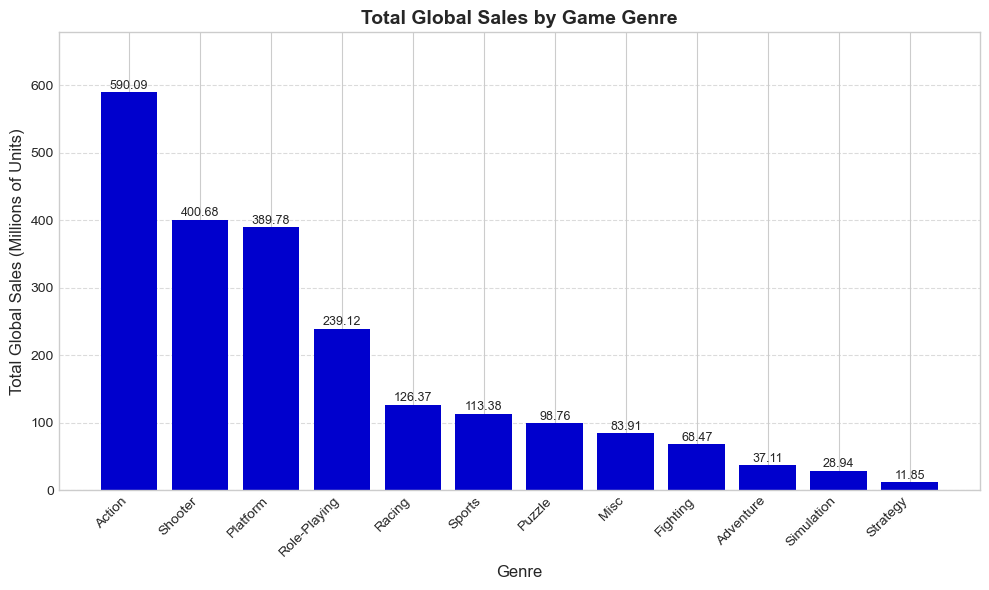

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset (already loaded in thought, but re-load for clean execution)
df = pd.read_csv('games_sales_merged.csv')

# --- Data Analysis ---

# Group by the single-entry 'Genre' column and calculate total Global_Sales
genre_sales = df.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)

# Convert the Series to a DataFrame for cleaner display
genre_sales_df = genre_sales.to_frame(name='Total Global Sales (Millions)').reset_index()

# --- Visualization for Jupyter Notebook ---

# Set a style for the plot
plt.style.use('seaborn-v0_8-whitegrid')

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(genre_sales_df['Genre'], genre_sales_df['Total Global Sales (Millions)'], color='mediumblue')

# Add the value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    # Only label genres with significant sales to avoid clutter
    if yval > 5:
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

# Set labels and title
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Total Global Sales (Millions of Units)', fontsize=12)
plt.title('Total Global Sales by Game Genre', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, genre_sales_df['Total Global Sales (Millions)'].max() * 1.15) # Adjust y-limit for labels

# Save the plot
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.savefig('global_sales_by_genre.png')

# Print the data to display the results
print("Total Global Sales by Game Genre (in Millions of Units):")
print(genre_sales_df)

22. How does user rating affect global sales?

Pearson Correlation between User Rating and Global Sales: 0.0728


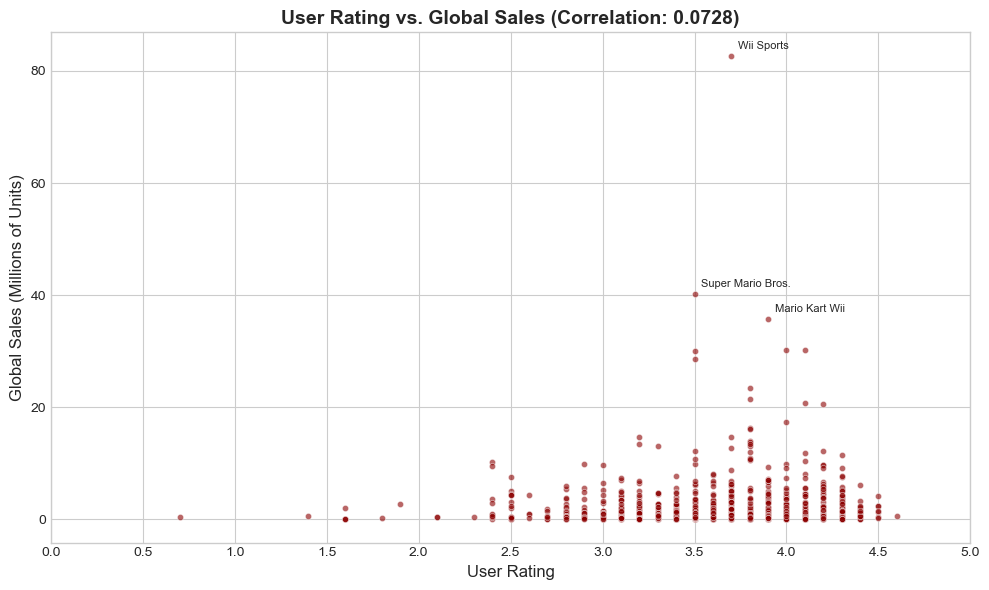

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('games_sales_merged.csv')

# --- Data Cleaning and Correlation ---

# Select relevant columns and drop rows with NaN in these columns
analysis_df = df[['Rating', 'Global_Sales']].dropna()

# Calculate the Pearson correlation coefficient
correlation = analysis_df['Rating'].corr(analysis_df['Global_Sales'])

# Print the correlation result
print(f"Pearson Correlation between User Rating and Global Sales: {correlation:.4f}")

# --- Visualization for Jupyter Notebook (Scatter Plot) ---

plt.style.use('seaborn-v0_8-whitegrid')

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(analysis_df['Rating'], analysis_df['Global_Sales'], 
            alpha=0.6, s=20, color='darkred', edgecolors='w', linewidths=0.5)

# Add a title and labels
plt.title(f'User Rating vs. Global Sales (Correlation: {correlation:.4f})', 
          fontsize=14, fontweight='bold')
plt.xlabel('User Rating', fontsize=12)
plt.ylabel('Global Sales (Millions of Units)', fontsize=12)

# Set X-axis limits based on typical rating scales (0 to 5)
plt.xlim(0, 5)
plt.xticks(np.arange(0, 5.1, 0.5))

# Annotate a few high-sales, high-rating points to give context (optional, but helpful)
# Let's find the top 3 highest selling games in the scatter plot data
top_3_sales = analysis_df.nlargest(3, 'Global_Sales')
for i in top_3_sales.index:
    # Use the original DataFrame to get the Game_Title
    title = df.loc[i, 'Game_Title']
    plt.annotate(title, 
                 (analysis_df.loc[i, 'Rating'], analysis_df.loc[i, 'Global_Sales']),
                 textcoords="offset points", 
                 xytext=(5, 5), 
                 ha='left', 
                 fontsize=8)

# Save the plot
plt.tight_layout()
plt.savefig('rating_vs_global_sales.png')

23. Which platforms have the most games with high ratings (e.g., above 4)?

Top 10 Platforms by Count of Highly-Rated Games (Rating > 4.0):
| Platform   | Count of Games with Rating > 4.0   |
|:-----------|:-----------------------------------|
| PS2        | 23                                 |
| PS3        | 19                                 |
| PC         | 16                                 |
| PS         | 14                                 |
| X360       | 13                                 |
| SNES       | 12                                 |
| DS         | 11                                 |
| PS4        | 11                                 |
| 3DS        | 9                                  |
| GC         | 9                                  |

Data saved to top_10_platforms_by_high_rating_count.csv


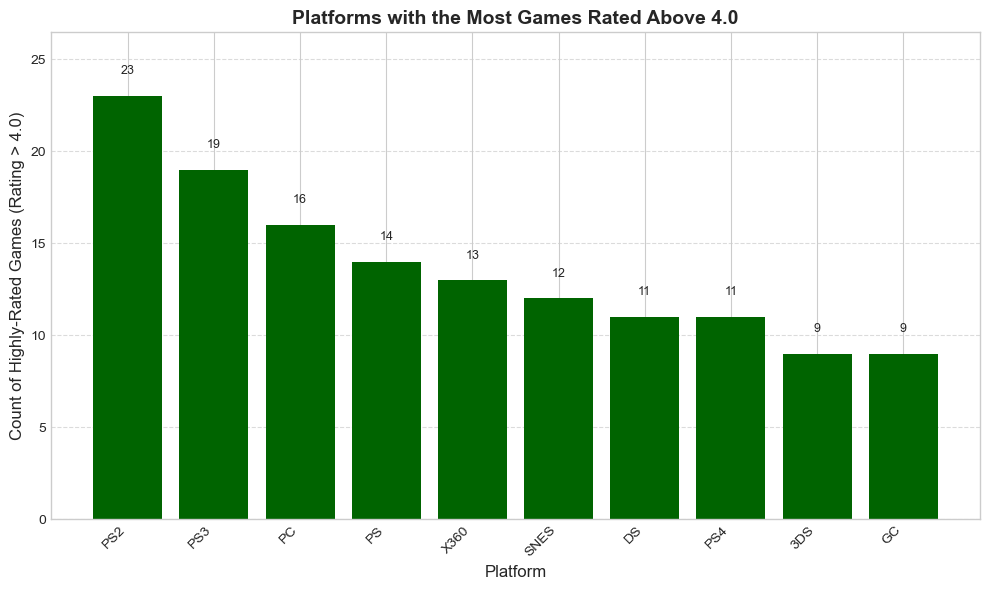

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('games_sales_merged.csv')

# --- Data Analysis ---

# 1. Filter for games with a high rating (Rating > 4.0)
high_rating_df = df[df['Rating'] > 4.0].dropna(subset=['Rating'])

# 2. Group by Platform and count the number of high-rated games
platform_high_ratings = high_rating_df.groupby('Platform').size().sort_values(ascending=False)
platform_high_ratings.name = 'Count of Games with Rating > 4.0'

# 3. Select the top 10 platforms
top_10_platforms = platform_high_ratings.head(10).to_frame().reset_index()

# Print the top 10 data
print("Top 10 Platforms by Count of Highly-Rated Games (Rating > 4.0):")
print(top_10_platforms.to_markdown(index=False, numalign="left", stralign="left"))

# --- Visualization for Jupyter Notebook ---

# Set a style for the plot
plt.style.use('seaborn-v0_8-whitegrid')

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_platforms['Platform'], top_10_platforms['Count of Games with Rating > 4.0'], color='darkgreen')

# Add the value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{int(yval)}', ha='center', va='bottom', fontsize=9)

# Set labels and title
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Count of Highly-Rated Games (Rating > 4.0)', fontsize=12)
plt.title('Platforms with the Most Games Rated Above 4.0', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, top_10_platforms['Count of Games with Rating > 4.0'].max() * 1.15) 

# Save the plot
plt.tight_layout()
plt.savefig('platforms_by_high_rating_count.png')

# Output the data to a CSV for user reference, especially for Power BI
top_10_platforms.to_csv('top_10_platforms_by_high_rating_count.csv', index=False)
print("\nData saved to top_10_platforms_by_high_rating_count.csv")

24. What’s the trend of releases and sales over time?

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19720\2215894314.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Year'] = df_cleaned['Year'].astype(int)


Yearly Trends for Releases and Sales:
| Year   | Release Count   | Total Global Sales (Millions)   |
|:-------|:----------------|:--------------------------------|
| 1981   | 1               | 1.65                            |
| 1982   | 1               | 7.81                            |
| 1984   | 1               | 1.22                            |
| 1985   | 1               | 40.24                           |
| 1986   | 2               | 7.74                            |

... Tail:
| Year   | Release Count   | Total Global Sales (Millions)   |
|:-------|:----------------|:--------------------------------|
| 2012   | 73              | 131.04                          |
| 2013   | 91              | 188.53                          |
| 2014   | 84              | 127.21                          |
| 2015   | 54              | 66.26                           |
| 2016   | 48              | 23.46                           |

Data saved to sales_releases_trend_over_time.csv


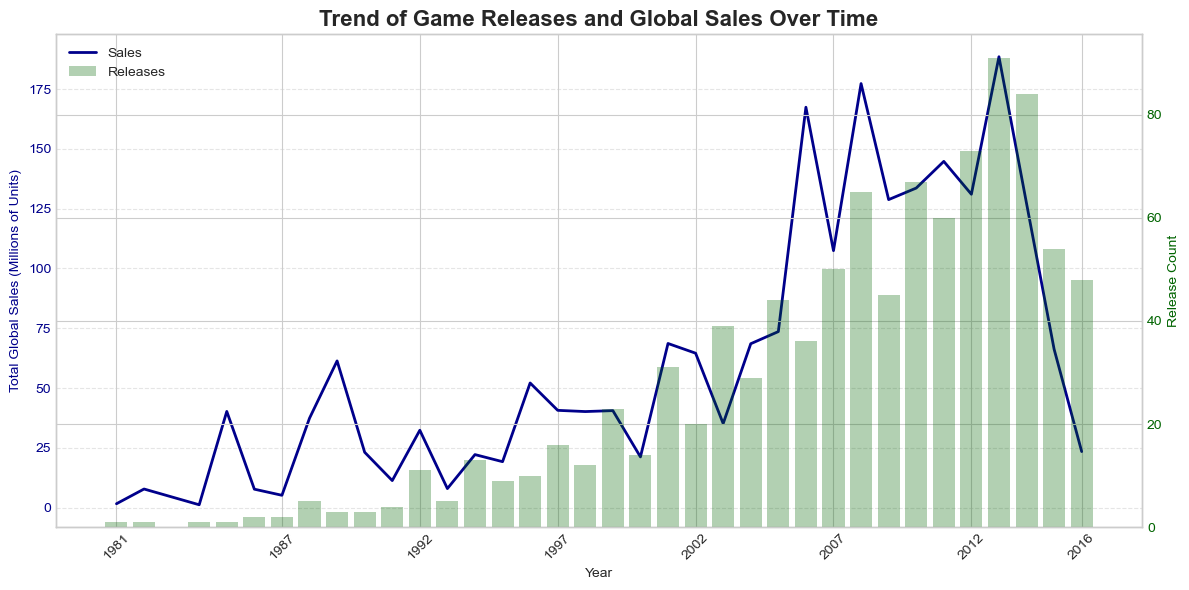

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('games_sales_merged.csv')

# --- Data Preparation ---

# 1. Clean and prepare Year column
df_cleaned = df.dropna(subset=['Year'])
df_cleaned['Year'] = df_cleaned['Year'].astype(int)

# 2. Calculate Releases (Count of games by Year)
releases_by_year = df_cleaned.groupby('Year').size().rename('Release Count')

# 3. Calculate Sales (Sum of Global_Sales by Year)
sales_by_year = df_cleaned.groupby('Year')['Global_Sales'].sum().rename('Total Global Sales (Millions)')

# 4. Combine data for analysis
trend_df = pd.concat([releases_by_year, sales_by_year], axis=1)

# Print the data to display the results
print("Yearly Trends for Releases and Sales:")
print(trend_df.head().to_markdown(numalign="left", stralign="left"))
print("\n... Tail:")
print(trend_df.tail().to_markdown(numalign="left", stralign="left"))


# --- Visualization for Jupyter Notebook (Dual-Axis Plot) ---

plt.style.use('seaborn-v0_8-whitegrid')

fig, ax1 = plt.subplots(figsize=(12, 6))

# Set up the first axis (Sales - Line Plot)
color = 'darkblue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Global Sales (Millions of Units)', color=color)
sales_line = ax1.plot(trend_df.index, trend_df['Total Global Sales (Millions)'], color=color, linewidth=2, label='Sales')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Set up the second axis (Releases - Bar Plot)
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'darkgreen'
ax2.set_ylabel('Release Count', color=color)
releases_bar = ax2.bar(trend_df.index, trend_df['Release Count'], width=0.8, color=color, alpha=0.3, label='Releases')
ax2.tick_params(axis='y', labelcolor=color)

# Set title
plt.title('Trend of Game Releases and Global Sales Over Time', fontsize=16, fontweight='bold')

# Adjust X-axis ticks for readability (show every 5th year)
years = trend_df.index.tolist()
tick_years = years[::5] + [years[-1]] if years[-1] not in years[::5] else years[::5]
ax1.set_xticks(tick_years)
ax1.tick_params(axis='x', rotation=45)

# Combine legends
lines = sales_line + [releases_bar]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

# Save the plot
plt.tight_layout()
plt.savefig('sales_releases_trend_over_time.png')

# Save the data to CSV
trend_df.to_csv('sales_releases_trend_over_time.csv')
print("\nData saved to sales_releases_trend_over_time.csv")

25. Do highly wishlisted games lead to more sales?

Pearson Correlation between Wishlist Count and Global Sales: -0.0308

Data saved to wishlist_vs_global_sales_data.csv


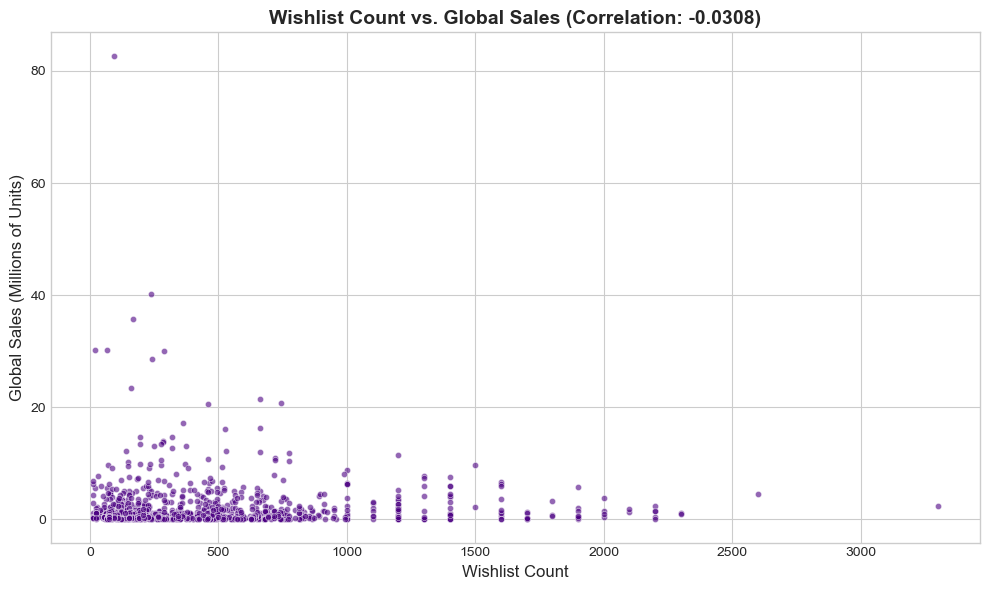

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('games_sales_merged.csv')

# --- Data Cleaning and Correlation ---

# Select relevant columns and drop rows with NaN in these columns
analysis_df = df[['Wishlist', 'Global_Sales']].dropna()

# Calculate the Pearson correlation coefficient
correlation = analysis_df['Wishlist'].corr(analysis_df['Global_Sales'])

# Print the correlation result
print(f"Pearson Correlation between Wishlist Count and Global Sales: {correlation:.4f}")

# --- Visualization for Jupyter Notebook (Scatter Plot) ---

plt.style.use('seaborn-v0_8-whitegrid')

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(analysis_df['Wishlist'], analysis_df['Global_Sales'], 
            alpha=0.6, s=20, color='indigo', edgecolors='w', linewidths=0.5)

# Add a title and labels
plt.title(f'Wishlist Count vs. Global Sales (Correlation: {correlation:.4f})', 
          fontsize=14, fontweight='bold')
plt.xlabel('Wishlist Count', fontsize=12)
plt.ylabel('Global Sales (Millions of Units)', fontsize=12)

# Save the plot
plt.tight_layout()
plt.savefig('wishlist_vs_global_sales.png')

# Output the data to a CSV for user reference, especially for Power BI
analysis_df.to_csv('wishlist_vs_global_sales_data.csv', index=False)
print("\nData saved to wishlist_vs_global_sales_data.csv")

26. Which genres have the highest engagement but lowest sales?

Genres with Highest Engagement but Lowest Sales (Filtered List):
| Genre     | Total_Sales   | Avg_Wishlist   | Avg_Plays   | Sales_Rank   | Wishlist_Rank   |
|:----------|:--------------|:---------------|:------------|:-------------|:----------------|
| Adventure | 37.11         | 523.967        | 6047.4      | 3            | 3               |
| Strategy  | 11.85         | 213.133        | 5854.67     | 1            | 6               |
| Misc      | 83.91         | 159.611        | 10422.2     | 5            | 9               |

Full analysis data saved to genre_sales_engagement_analysis.csv


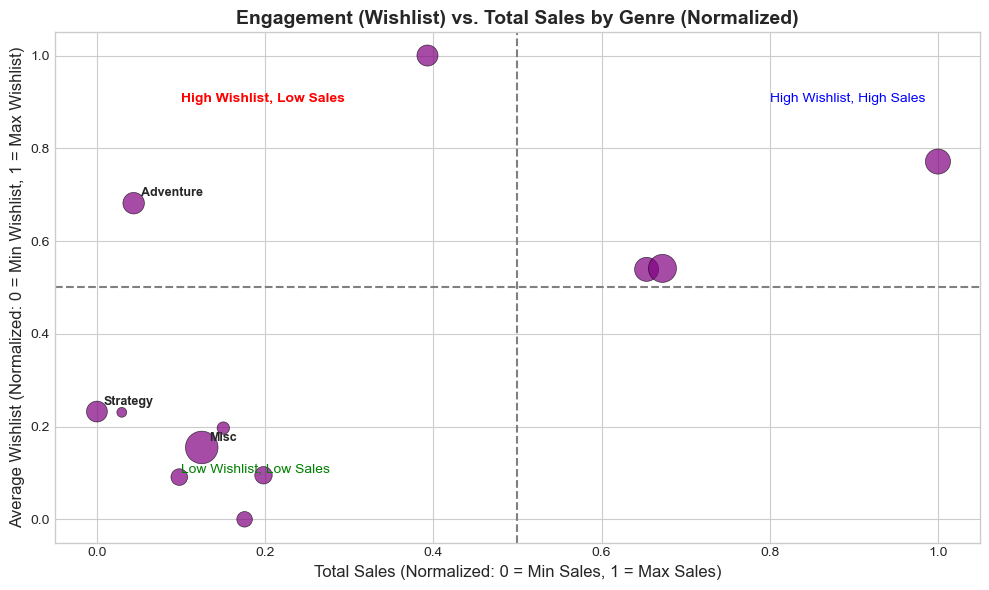

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the dataset
df = pd.read_csv('games_sales_merged.csv')

# --- Data Analysis ---

# 1. Filter out rows with missing values in relevant columns
engagement_cols = ['Genre', 'Global_Sales', 'Wishlist', 'Plays']
analysis_df = df[engagement_cols].dropna()

# 2. Group by Genre and calculate aggregated metrics
genre_analysis = analysis_df.groupby('Genre').agg(
    Total_Sales=('Global_Sales', 'sum'),
    Avg_Wishlist=('Wishlist', 'mean'),
    Avg_Plays=('Plays', 'mean')
).reset_index()

# 3. Normalize the metrics (Min-Max Scaling) for comparison
scaler = MinMaxScaler()
metrics_to_normalize = ['Total_Sales', 'Avg_Wishlist', 'Avg_Plays']
genre_analysis[['Norm_Sales', 'Norm_Wishlist', 'Norm_Plays']] = scaler.fit_transform(
    genre_analysis[metrics_to_normalize]
)

# 4. Calculate a composite "Engagement Rank" and "Sales Rank"
# Ranks are assigned in ascending order (1 = highest, N = lowest)
genre_analysis['Sales_Rank'] = genre_analysis['Total_Sales'].rank(ascending=True)
genre_analysis['Wishlist_Rank'] = genre_analysis['Avg_Wishlist'].rank(ascending=False)
genre_analysis['Plays_Rank'] = genre_analysis['Avg_Plays'].rank(ascending=False)

# 5. Identify genres with High Engagement (high Wishlist/Plays rank) and Low Sales (low Sales rank)
# Look for genres where Sales_Rank is low (low sales) and Wishlist_Rank/Plays_Rank is high (high engagement)
# Let's filter for genres in the bottom half for Sales_Rank and top half for at least one engagement metric.
num_genres = len(genre_analysis)
low_sales_high_engagement = genre_analysis[
    (genre_analysis['Sales_Rank'] <= num_genres / 2) &  # Sales in the bottom half (lower sales)
    ((genre_analysis['Wishlist_Rank'] <= num_genres / 2) | (genre_analysis['Plays_Rank'] <= num_genres / 2)) # At least one engagement metric in the top half (higher engagement)
].sort_values(by=['Wishlist_Rank', 'Plays_Rank', 'Sales_Rank'], ascending=[True, True, False]) # Sort to put best matches first

# Print the table of interest
print("Genres with Highest Engagement but Lowest Sales (Filtered List):")
print(low_sales_high_engagement[['Genre', 'Total_Sales', 'Avg_Wishlist', 'Avg_Plays', 'Sales_Rank', 'Wishlist_Rank']].to_markdown(index=False, numalign="left", stralign="left"))


# --- Visualization for Jupyter Notebook (Scatter Plot of Normalized Metrics) ---
# Use normalized metrics to show divergence

plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))

# Define metrics for the scatter plot
x_metric = 'Norm_Sales'
y_metric = 'Norm_Wishlist'
size_metric = 'Norm_Plays' # Use normalized plays for point size

scatter = ax.scatter(
    genre_analysis[x_metric], 
    genre_analysis[y_metric], 
    s=genre_analysis[size_metric] * 500 + 50, # Scale size for visibility
    alpha=0.7, 
    color='purple', 
    edgecolors='k', 
    linewidths=0.5
)

# Label the most divergent genres (High Y, Low X)
for index, row in low_sales_high_engagement.head(3).iterrows():
    ax.annotate(row['Genre'], 
                (row[x_metric], row[y_metric]),
                textcoords="offset points", 
                xytext=(5, 5), 
                ha='left', 
                fontsize=9, 
                fontweight='bold')

# Draw lines to define quadrants
ax.axhline(0.5, color='gray', linestyle='--')
ax.axvline(0.5, color='gray', linestyle='--')

# Set labels and title
ax.set_title('Engagement (Wishlist) vs. Total Sales by Genre (Normalized)', fontsize=14, fontweight='bold')
ax.set_xlabel('Total Sales (Normalized: 0 = Min Sales, 1 = Max Sales)', fontsize=12)
ax.set_ylabel('Average Wishlist (Normalized: 0 = Min Wishlist, 1 = Max Wishlist)', fontsize=12)

# Annotate the quadrant of interest
ax.text(0.1, 0.9, 'High Wishlist, Low Sales', color='red', fontsize=10, fontweight='bold')
ax.text(0.1, 0.1, 'Low Wishlist, Low Sales', color='green', fontsize=10)
ax.text(0.8, 0.9, 'High Wishlist, High Sales', color='blue', fontsize=10)


# Save the plot
plt.tight_layout()
plt.savefig('genre_engagement_vs_sales.png')

# Save the full normalized data table
genre_analysis.to_csv('genre_sales_engagement_analysis.csv', index=False)
print("\nFull analysis data saved to genre_sales_engagement_analysis.csv")

27. Do highly listed games (wishlist/backlogs) correlate with better ratings?

Pearson Correlation between Wishlist Count and Rating: 0.5113
Pearson Correlation between Backlogs Count and Rating: 0.4527

Analysis data saved to listing_metrics_vs_rating_data.csv


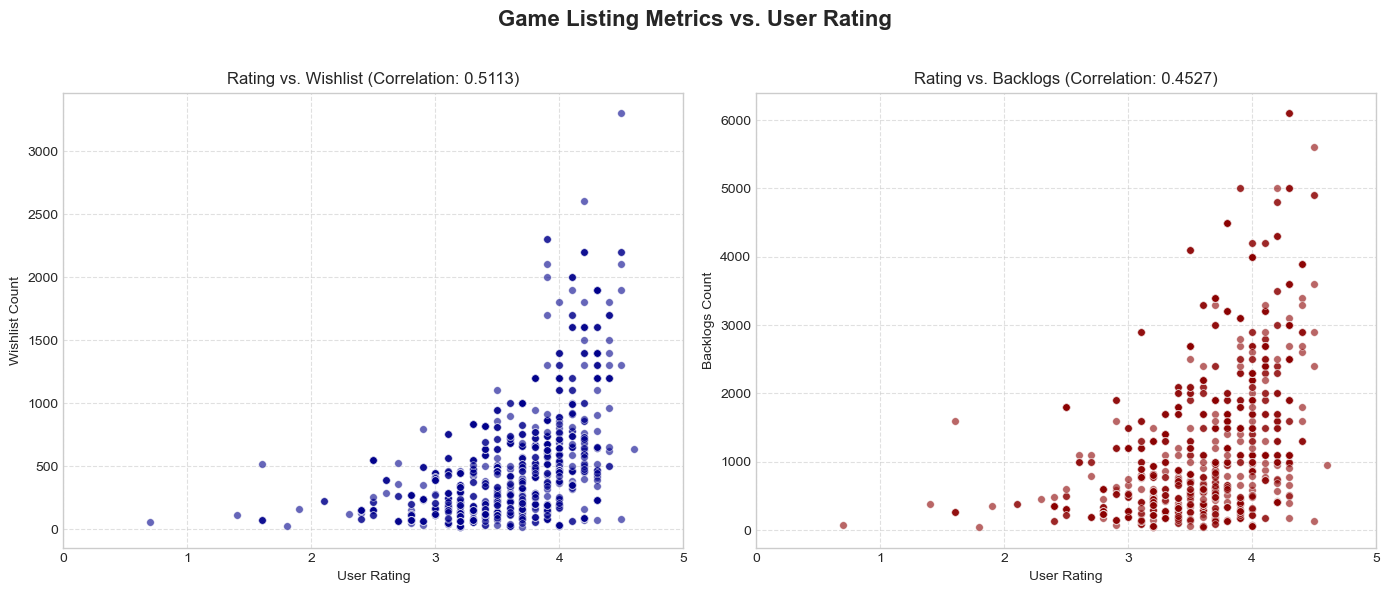

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('games_sales_merged.csv')

# --- Data Cleaning and Correlation ---

# Select relevant columns and drop rows with NaN in these columns
analysis_df = df[['Rating', 'Wishlist', 'Backlogs']].dropna()

# Calculate Pearson correlation coefficients
corr_wishlist_rating = analysis_df['Wishlist'].corr(analysis_df['Rating'])
corr_backlogs_rating = analysis_df['Backlogs'].corr(analysis_df['Rating'])

# Print correlation results
print(f"Pearson Correlation between Wishlist Count and Rating: {corr_wishlist_rating:.4f}")
print(f"Pearson Correlation between Backlogs Count and Rating: {corr_backlogs_rating:.4f}")

# --- Visualization for Jupyter Notebook (Two Subplots) ---

plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Game Listing Metrics vs. User Rating', fontsize=16, fontweight='bold')

# --- Subplot 1: Wishlist vs. Rating ---
axes[0].scatter(analysis_df['Rating'], analysis_df['Wishlist'], 
                alpha=0.6, s=30, color='darkblue', edgecolors='w', linewidths=0.5)
axes[0].set_title(f'Rating vs. Wishlist (Correlation: {corr_wishlist_rating:.4f})', fontsize=12)
axes[0].set_xlabel('User Rating', fontsize=10)
axes[0].set_ylabel('Wishlist Count', fontsize=10)
axes[0].set_xlim(0, 5)
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- Subplot 2: Backlogs vs. Rating ---
axes[1].scatter(analysis_df['Rating'], analysis_df['Backlogs'], 
                alpha=0.6, s=30, color='darkred', edgecolors='w', linewidths=0.5)
axes[1].set_title(f'Rating vs. Backlogs (Correlation: {corr_backlogs_rating:.4f})', fontsize=12)
axes[1].set_xlabel('User Rating', fontsize=10)
axes[1].set_ylabel('Backlogs Count', fontsize=10)
axes[1].set_xlim(0, 5)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Save the plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
plt.savefig('listing_metrics_vs_rating.png')

# Output the data to a CSV for user reference, especially for Power BI
analysis_df.to_csv('listing_metrics_vs_rating_data.csv', index=False)
print("\nAnalysis data saved to listing_metrics_vs_rating_data.csv")

28. How does user engagement differ across genres?

Top 5 Genres by Composite Engagement Score (Average Raw Values):
| Genre        | Avg_Plays   | Avg_Playing   | Avg_Backlogs   | Avg_Wishlist   | Avg_Reviews   |
|:-------------|:------------|:--------------|:---------------|:---------------|:--------------|
| Shooter      | 8415.34     | 111.546       | 1290.36        | 426.724        | 724.344       |
| Action       | 7269.47     | 147.991       | 1443.2         | 586.086        | 763.403       |
| Platform     | 6900.91     | 97.4622       | 1157.74        | 425.269        | 791.277       |
| Adventure    | 6047.4      | 104.667       | 1207.55        | 523.967        | 668.083       |
| Role-Playing | 5920.27     | 216.178       | 1859.34        | 744.253        | 818.267       |

Full engagement analysis data saved to genre_engagement_normalized_analysis.csv


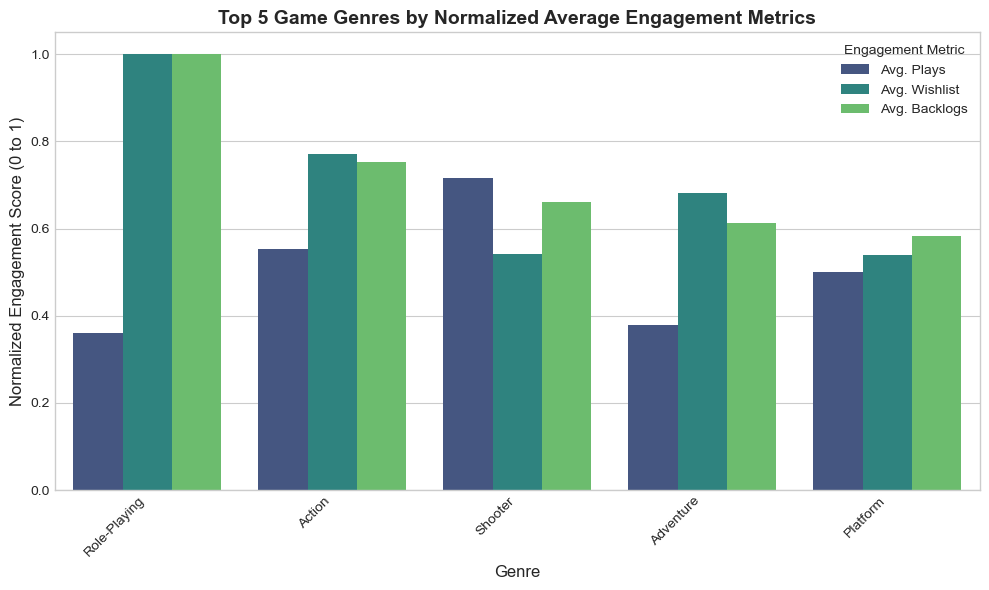

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the dataset
df = pd.read_csv('games_sales_merged.csv')

# --- Data Analysis ---

engagement_cols = ['Genre', 'Plays', 'Playing', 'Backlogs', 'Wishlist', 'Number of Reviews']
analysis_df = df[engagement_cols].dropna()

# 1. Group by Genre and calculate average engagement metrics
genre_engagement = analysis_df.groupby('Genre').agg(
    Avg_Plays=('Plays', 'mean'),
    Avg_Playing=('Playing', 'mean'),
    Avg_Backlogs=('Backlogs', 'mean'),
    Avg_Wishlist=('Wishlist', 'mean'),
    Avg_Reviews=('Number of Reviews', 'mean')
).reset_index()

# 2. Normalize the key metrics for visualization
metrics_to_normalize = ['Avg_Plays', 'Avg_Wishlist', 'Avg_Backlogs']
scaler = MinMaxScaler()
genre_engagement_normalized = genre_engagement.copy()
genre_engagement_normalized[['Norm_Plays', 'Norm_Wishlist', 'Norm_Backlogs']] = scaler.fit_transform(
    genre_engagement_normalized[metrics_to_normalize]
)

# 3. Calculate a composite engagement score and identify top genres
genre_engagement_normalized['Composite_Score'] = genre_engagement_normalized[['Norm_Plays', 'Norm_Wishlist', 'Norm_Backlogs']].mean(axis=1)

top_genres = genre_engagement_normalized.sort_values(by='Composite_Score', ascending=False).head(5)

# Prepare data for visualization (melt the normalized data)
vis_df = top_genres[['Genre', 'Norm_Plays', 'Norm_Wishlist', 'Norm_Backlogs']].melt(
    id_vars='Genre', 
    var_name='Metric', 
    value_name='Normalized Score'
)
# Rename metrics for readability
vis_df['Metric'] = vis_df['Metric'].replace({
    'Norm_Plays': 'Avg. Plays', 
    'Norm_Wishlist': 'Avg. Wishlist', 
    'Norm_Backlogs': 'Avg. Backlogs'
})

# Print the top 5 raw data
print("Top 5 Genres by Composite Engagement Score (Average Raw Values):")
print(genre_engagement.loc[genre_engagement['Genre'].isin(top_genres['Genre'])].sort_values(by='Avg_Plays', ascending=False).to_markdown(index=False, numalign="left", stralign="left"))


# --- Visualization for Jupyter Notebook (Grouped Bar Chart of Normalized Metrics) ---

plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(10, 6))
import seaborn as sns
sns.barplot(x='Genre', y='Normalized Score', hue='Metric', data=vis_df, palette='viridis')

# Set labels and title
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Normalized Engagement Score (0 to 1)', fontsize=12)
plt.title('Top 5 Game Genres by Normalized Average Engagement Metrics', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Engagement Metric', loc='upper right')
plt.ylim(0, 1.05)

# Save the plot
plt.tight_layout()
plt.savefig('genre_engagement_comparison.png')

# Save the full normalized data table
genre_engagement_normalized.to_csv('genre_engagement_normalized_analysis.csv', index=False)
print("\nFull engagement analysis data saved to genre_engagement_normalized_analysis.csv")

29. What are the top-performing combinations of Genre + Platform?

Top 10 Performing Genre + Platform Combinations:
| Combination    | Total Global Sales (Millions)   |
|:---------------|:--------------------------------|
| Platform - DS  | 50.14                           |
| Puzzle - GB    | 60.52                           |
| Platform - Wii | 65.47                           |
| Platform - NES | 70.79                           |
| Sports - Wii   | 85.53                           |
| Action - X360  | 100.13                          |
| Shooter - PS3  | 106.19                          |
| Action - PS2   | 106.45                          |
| Action - PS3   | 142.43                          |
| Shooter - X360 | 162.56                          |

Data saved to top_10_genre_platform_combinations.csv


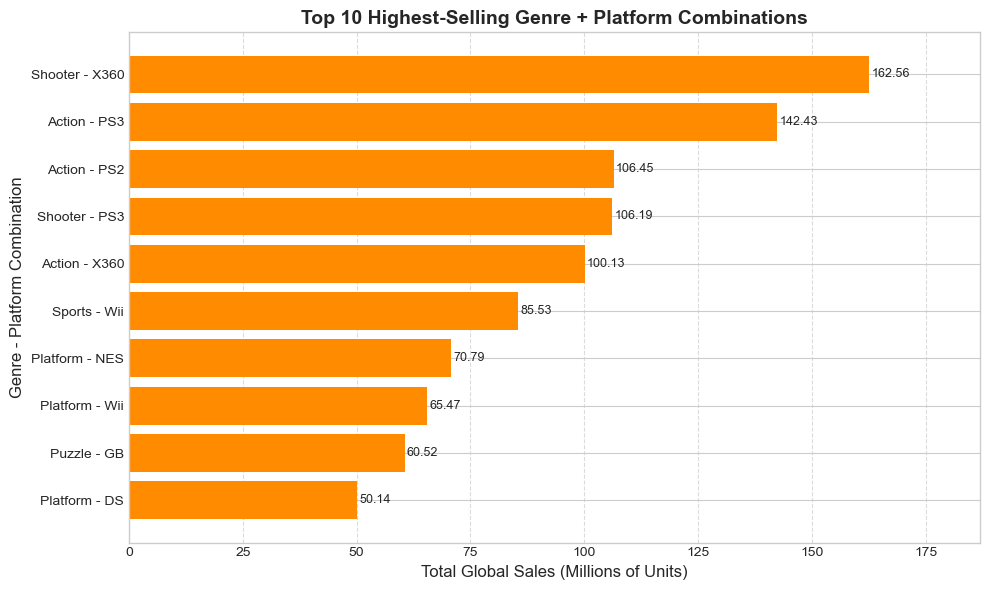

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('games_sales_merged.csv')

# --- Data Analysis ---

# 1. Group by Genre and Platform, and sum Global_Sales
genre_platform_sales = df.groupby(['Genre', 'Platform'])['Global_Sales'].sum().sort_values(ascending=False)

# 2. Select the top 10 combinations
top_10_combinations = genre_platform_sales.head(10).to_frame().reset_index()

# 3. Create a combined column for visualization
top_10_combinations['Combination'] = top_10_combinations['Genre'] + ' - ' + top_10_combinations['Platform']

# Rename column for clarity
top_10_combinations.columns = ['Genre', 'Platform', 'Total Global Sales (Millions)', 'Combination']

# Sort by sales again (to ensure the bar chart order is correct)
top_10_combinations = top_10_combinations.sort_values(by='Total Global Sales (Millions)', ascending=True)

# Print the top 10 data
print("Top 10 Performing Genre + Platform Combinations:")
print(top_10_combinations[['Combination', 'Total Global Sales (Millions)']].to_markdown(index=False, numalign="left", stralign="left"))

# --- Visualization for Jupyter Notebook (Horizontal Bar Chart) ---

# Set a style for the plot
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(10, 6))

# Create the horizontal bar chart
bars = plt.barh(top_10_combinations['Combination'], top_10_combinations['Total Global Sales (Millions)'], color='darkorange')

# Add the value labels at the end of the bars
for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 0.5, bar.get_y() + bar.get_height()/2, f'{xval:.2f}', va='center', fontsize=9)

# Set labels and title
plt.xlabel('Total Global Sales (Millions of Units)', fontsize=12)
plt.ylabel('Genre - Platform Combination', fontsize=12)
plt.title('Top 10 Highest-Selling Genre + Platform Combinations', fontsize=14, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, top_10_combinations['Total Global Sales (Millions)'].max() * 1.15) # Adjust x-limit for labels

# Save the plot
plt.tight_layout()
plt.savefig('top_10_genre_platform_combinations.png')

# Output the data to a CSV for user reference
top_10_combinations.to_csv('top_10_genre_platform_combinations.csv', index=False)
print("\nData saved to top_10_genre_platform_combinations.csv")

30. What does a regional sales heatmap by genre reveal?

Normalized Regional Sales by Genre (0=Lowest Regional Sales for that Genre, 1=Highest):
| Genre     | NA_Sales   | EU_Sales   | JP_Sales   | Other_Sales   |
|:----------|:-----------|:-----------|:-----------|:--------------|
| Action    | 1          | 0.605429   | 0          | 0.1441        |
| Adventure | 1          | 0.583138   | 0.199844   | 0             |
| Fighting  | 1          | 0.315789   | 0.168287   | 0             |
| Misc      | 1          | 0.456159   | 0          | 0.114301      |
| Platform  | 1          | 0.378585   | 0.218867   | 0             |

Normalized data saved to normalized_regional_sales_by_genre.csv


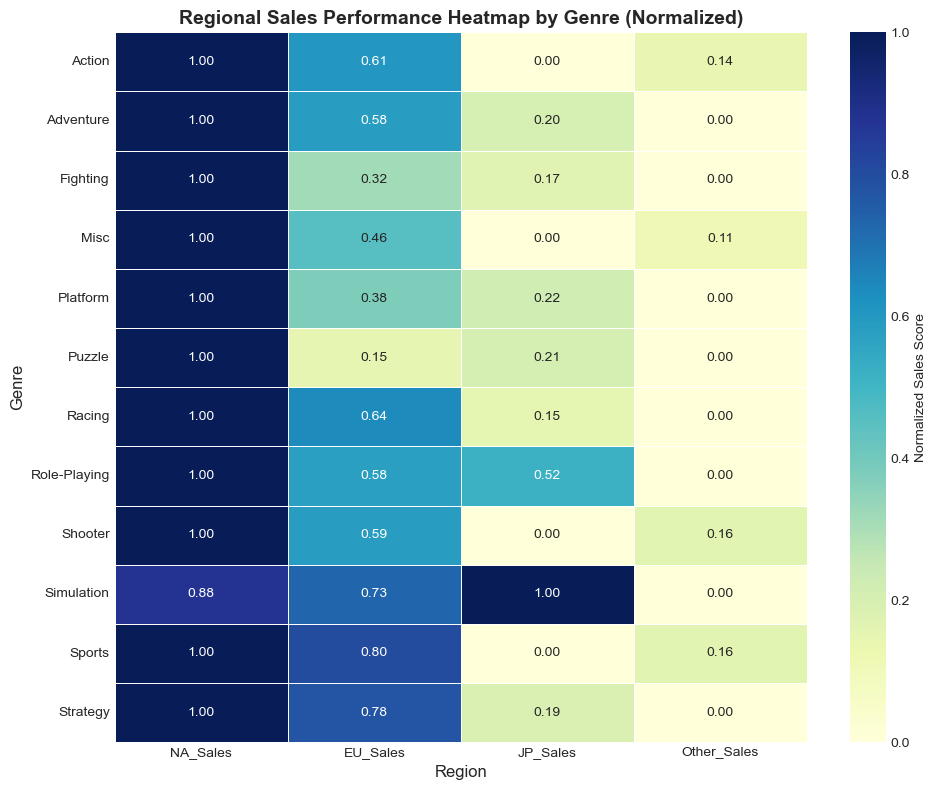

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the dataset
df = pd.read_csv('games_sales_merged.csv')

# --- Data Preparation and Aggregation ---

regional_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

# 1. Group by Genre and sum regional sales
genre_regional_sales = df.groupby('Genre')[regional_cols].sum()

# 2. Normalize the data across regions (Min-Max scaling across rows)
# The scaler is fitted on each row (each genre) to show the relative strength of that genre across regions.
normalized_sales = genre_regional_sales.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0, axis=1)

# Handle cases where all sales for a genre are 0 (resulting in NaN or 0), though unlikely for major genres
normalized_sales = normalized_sales.fillna(0)

# Print a sample of the normalized data
print("Normalized Regional Sales by Genre (0=Lowest Regional Sales for that Genre, 1=Highest):")
print(normalized_sales.head().to_markdown(numalign="left", stralign="left"))


# --- Visualization for Jupyter Notebook (Heatmap) ---

plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(10, 8))
# Create the heatmap
sns.heatmap(
    normalized_sales, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    linewidths=.5, 
    cbar_kws={'label': 'Normalized Sales Score'}
)

# Set labels and title
plt.title('Regional Sales Performance Heatmap by Genre (Normalized)', fontsize=14, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.xticks(rotation=0) # Keep region labels horizontal

# Save the plot
plt.tight_layout()
plt.savefig('regional_sales_heatmap_by_genre.png')

# Save the normalized data to CSV
normalized_sales.to_csv('normalized_regional_sales_by_genre.csv')
print("\nNormalized data saved to normalized_regional_sales_by_genre.csv")